In [1]:
import os
import numpy as np
import mne
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
import sails
from mne.viz.utils import center_cmap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA
#from autoreject import AutoReject
from scipy import signal
import pickle
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from scipy.spatial import distance_matrix
from scipy.io import savemat, loadmat
from scipy.stats import pearsonr
from matplotlib.colors import TwoSlopeNorm
from pyedfread import edf

from mne import Epochs, create_info, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import AverageTFR

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

%matplotlib widget
plt.rcParams['figure.figsize'] = [9, 8]

dataset_path = os.path.join('rich_data', 'subj2', 'preproc25hz', 'task_part2_1_raw_tsss_mc_ica.fif')
high_pass = 0.1
low_pass = 124.999

In [2]:
raw_path = os.path.join('rich_data', 'subj2', 'preproc25hz', 'task_part1_1_raw_tsss_mc_raw.fif')

In [7]:
ica = mne.preprocessing.read_ica(dataset_path)
#raw = mne.io.read_raw_fif(raw_path)

Reading rich_data/subj2/preproc25hz_eeg/task_part2_1_raw_tsss_mc_ica.fif ...
Now restoring ICA solution ...
Ready.


/var/folders/nv/wjmf18wd5_j38vg9v0cthl5h0000gn/T/ipykernel_2368/4105401838.py:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.read_ica(dataset_path)


In [22]:
ica_sources = ica.get_sources(raw).get_data()

In [30]:
%matplotlib widget
plt.plot(ica_sources[5][20000:40000], linewidth=0.1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
ica.exclude

[0, 5, 3]

In [9]:
ica.plot_components()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x731.5 with 12 Axes>]

In [7]:
dataset_path = os.path.join('rich_data', 'subj1', 'maxfiltered',
                            'task_part4_5_raw_tsss_mc.fif')

raw = mne.io.read_raw_fif(dataset_path, preload=True, verbose=True, on_split_missing='warn')
raw_plot = raw.copy().pick_types(eeg=True, meg=False)

Opening raw data file rich_data/subj1/maxfiltered/task_part4_5_raw_tsss_mc.fif...
    Range : 34000 ... 557999 =     34.000 ...   557.999 secs
Ready.
Reading 0 ... 523999  =      0.000 ...   523.999 secs...


/var/folders/nv/wjmf18wd5_j38vg9v0cthl5h0000gn/T/ipykernel_2442/3099698117.py:4: RuntimeWarning: This filename (rich_data/subj1/maxfiltered/task_part4_5_raw_tsss_mc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(dataset_path, preload=True, verbose=True, on_split_missing='warn')


In [8]:
data = raw_plot.get_data()

In [4]:
data.shape

(60, 524000)

In [9]:
u, s, v = np.linalg.svd(data[:, :10000])

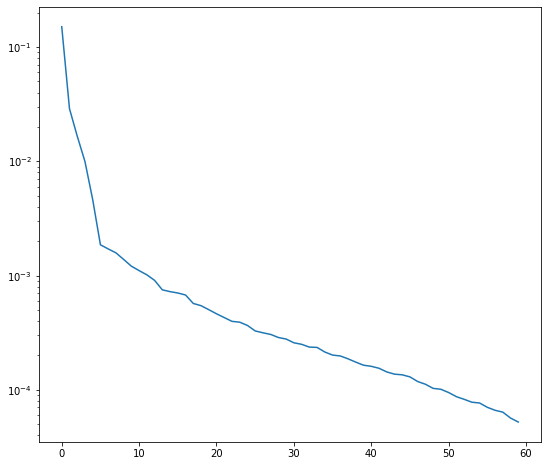

In [10]:
plt.semilogy(s)

In [30]:
raw_plot.plot(n_channels=100, decim=20, clipping=2, scalings='auto', duration=1000)
t = 0

/var/folders/nv/wjmf18wd5_j38vg9v0cthl5h0000gn/T/ipykernel_3241/2297973977.py:1: RuntimeWarning: The measurement information indicates a low-pass frequency of 25 Hz. The decim=20 parameter will result in a sampling frequency of 50 Hz, which can cause aliasing artifacts.
  raw_plot.plot(n_channels=100, decim=20, clipping=2, scalings='auto', duration=1000)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Load data

In [3]:
# Load data
raw = mne.io.read_raw_fif(raw_path, preload=True, verbose=True, on_split_missing='warn')

Opening raw data file rich_data/subj2/preproc25hz/task_part1_1_raw_tsss_mc_raw.fif...
    Range : 27000 ... 1158999 =     27.000 ...  1158.999 secs
Ready.
Reading 0 ... 1131999  =      0.000 ...  1131.999 secs...


In [26]:
raw.info

<Info | 24 non-empty values
 acq_pars: ACQactiveGround 1 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: []
 ch_names: EOG001, EOG002, ECG003, EMG004, EEG001, EEG002, EEG003, EEG004, ...
 chs: 2 EOG, 1 ECG, 1 EMG, 60 EEG, 11 IAS, 102 MAG, 204 GRAD, 6 MISC, 1 STIM, 1 SYST, 9 CHPI
 custom_ref_applied: False
 description: TRIUX system at OHBA-3143
 dev_head_t: MEG device -> head transform
 dig: 192 items (3 Cardinal, 5 HPI, 61 EEG, 123 Extra)
 events: 1 item (list)
 experimenter: csaky (csaky)
 file_id: 4 items (dict)
 gantry_angle: 68.0
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 330.0 Hz
 meas_date: 2022-01-17 11:37:18 UTC
 meas_id: 4 items (dict)
 nchan: 398
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: disp_mmxxi_cviii
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 4 items (dict)
>

In [23]:
# filter and downsample
raw = raw.filter(l_freq=1, h_freq=125)
#raw = raw.notch_filter(freqs=np.arange(50, 151, 50), phase='minimum')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 31.25 Hz (-6 dB cutoff frequency: 140.62 Hz)
- Filter length: 3301 samples (3.301 sec)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Setting 33599 of 1132000 (2.97%) samples to NaN, retaining 1098401 (97.03%) samples.
Effective window size : 2.048 (s)
Setting 33599 of 1132000 (2.97%) samples to NaN, retaining 1098401 (97.03%) samples.
Effective window size : 2.048 (s)
Setting 33599 of 1132000 (2.97%) samples to NaN, retaining 1098401 (97.03%) samples.
Effective window size : 2.048 (s)


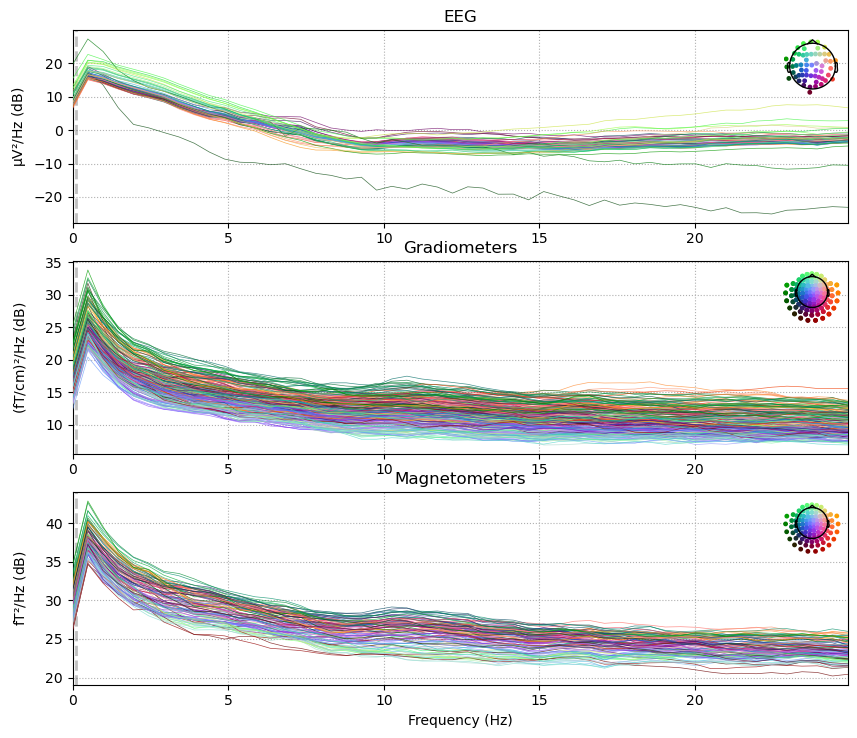

In [12]:
raw.plot_psd(fmax=25)

## Epoching

In [32]:
event_dict = {#'event_off':1,
              'words/hungry':2,
              'words/tired':3,
              'words/thirsty':4,
              'words/toilet':5,
              'words/pain':6,
              #'think':7,
              #'cue':8,
              #'buttons_shown':9,
              #'error':10,
              #'twords/hungry':11,
              #'twords/tired':12,
              #'twords/thirsty':13,
              #'twords/toilet':14,
              #'twords/pain':15,
              #'button/1':256,
              #'button/2':512,
              #'button/3':1024,
              #'button/4':2048
             }
'''
'twords/hungry/b1': 267,
'twords/hungry/b2': 523,
'twords/tired/b1': 268,
'twords/tired/b2': 524,
'twords/thirsty/b1': 269,
'twords/thirsty/b2': 525,
'twords/toilet/b1': 270,
'twords/toilet/b2': 526,
'twords/pain/b1': 271,
'twords/pain/b2': 527,
'twords/pain/b3': 1039,
'error/b3': 1034
'''

#reject = dict(grad=4000e-13, mag=4e-12)

epochs_cue = mne.Epochs(raw,
                    new_events,
                    decim=1,
                    event_id=event_dict,
                    tmin=-1,
                    tmax=1,
                    baseline=None,
                    reject=None,
                    preload=True)

Not setting metadata
Not setting metadata
133 matching events found
No baseline correction applied
0 projection items activated
Loading data for 133 events and 2001 original time points ...
1 bad epochs dropped


In [33]:
%matplotlib widget
plt.plot(epochs_cue[0].get_data()[0, 100])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [36]:
%matplotlib widget
plt.plot(raw_data[100, 23000:25000])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [4]:
events = mne.find_events(raw, min_duration=0.002)

Trigger channel has a non-zero initial value of 4 (consider using initial_event=True to detect this event)
936 events found
Event IDs: [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15  256  512 1024 2048]


In [28]:
epochs

<Epochs |  132 events (all good), -1 - 1 sec, baseline -1 – 0 sec, ~808.5 MB, data loaded,
 'words/hungry': 28
 'words/pain': 25
 'words/thirsty': 27
 'words/tired': 27
 'words/toilet': 25>

In [6]:
new_events = []
for i, e in enumerate(events):
    if e[2] == 8 and events[i-2][2] < 7:
        new_e = np.array([e[0], 0, events[i-2][2]])
        new_events.append(new_e)

In [7]:
new_events = np.array(new_events)

In [19]:
for i in range(150):
    print(events[i])

[49158     4     5]
[50024     0     1]
[50999     0     8]
[51843     0     1]
[52828     0     4]
[53794     0     1]
[54795     0     8]
[55671     0     1]
[56599     0     3]
[57481     0     1]
[58473     0     8]
[59424     0     1]
[60285     0     6]
[61200     0     1]
[62018     0     8]
[63010     0     1]
[63955     0     2]
[64904     0     1]
[65713     0     8]
[66530     0     1]
[81077     0     6]
[82068     0     1]
[83045     0     8]
[83954     0     1]
[84872     0     4]
[85797     0     1]
[86664     0     8]
[87532     0     1]
[88401     0     2]
[89200     0     1]
[90034     0     8]
[90876     0     1]
[91803     0     5]
[92794     0     1]
[93694     0     8]
[94654     0     1]
[95606     0     3]
[96440     0     1]
[97331     0     8]
[98249     0     1]
[99260     0     6]
[100234      0      1]
[101168      0      8]
[102160      0      1]
[103046      0      3]
[104004      0      1]
[104846      0      8]
[105714      0      1]
[106666      0     

In [ ]:
events[:100]

## MNE time-frequency decoding

In [123]:
# Assemble the classifier using scikit-learn pipeline
clf = make_pipeline(CSP(n_components=4, reg=None, log=True, norm_trace=False),
                    LinearDiscriminantAnalysis())
n_splits = 5  # how many folds to use for cross-validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Classification & time-frequency parameters
tmin, tmax = -0.1, 1.6
n_cycles = 10.  # how many complete cycles: used to define window size
min_freq = 1
max_freq = 45
n_freqs = 2  # how many frequency bins to use

# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = (n_cycles / np.max(freqs) / 2.)
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

# Instantiate label encoder
le = LabelEncoder()

In [ ]:
# init scores
events = mne.find_events(raw, min_duration=0.002)
event_id = {'hungry': 2, 'tired': 3}
freq_scores = np.zeros((n_freqs - 1,))
raw_eeg = raw.copy().pick_types(meg=True, eeg=False, stim=False, eog=False, ecg=False, exclude='bads')

# Loop through each frequency range of interest
for freq, (fmin, fmax) in enumerate(freq_ranges):

    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.)  # in seconds

    # Apply band-pass filter to isolate the specified frequencies
    raw_filter = raw_eeg.copy().filter(fmin, fmax, n_jobs=1, fir_design='firwin',
                                   skip_by_annotation='edge')

    # Extract epochs from filtered data, padded by window size
    epochs = Epochs(raw_filter, events, event_id, tmin - w_size, tmax + w_size,
                    proj=False, baseline=None, preload=True, decim=4)
    epochs.drop_bad()
    y = le.fit_transform(epochs.events[:, 2])

    X = epochs.get_data()

    # Save mean scores over folds for each frequency and time window
    freq_scores[freq] = np.mean(cross_val_score(estimator=clf, X=X, y=y,
                                                scoring='roc_auc', cv=cv,
                                                n_jobs=1), axis=0)

Text(0.5, 1.0, 'Frequency Decoding Scores')

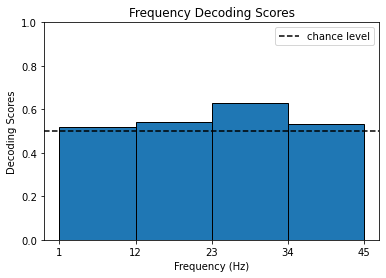

In [100]:
plt.bar(freqs[:-1], freq_scores, width=np.diff(freqs)[0],
        align='edge', edgecolor='black')
plt.xticks(freqs)
plt.ylim([0, 1])
plt.axhline(len(epochs['hungry']) / len(epochs), color='k', linestyle='--',
            label='chance level')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Decoding Scores')
plt.title('Frequency Decoding Scores')

In [ ]:
# init scores
tf_scores = np.zeros((n_freqs - 1, n_windows))
raw_eeg = raw.copy().pick_types(meg=True, eeg=False, stim=False, eog=False, ecg=False, exclude='bads')

# Loop through each frequency range of interest
for freq, (fmin, fmax) in enumerate(freq_ranges):

    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.)  # in seconds

    # Apply band-pass filter to isolate the specified frequencies
    raw_filter = raw_eeg.copy().filter(fmin, fmax, n_jobs=1, fir_design='firwin',
                                   skip_by_annotation='edge')

    # Extract epochs from filtered data, padded by window size
    epochs = Epochs(raw_filter, events, event_id, tmin - w_size, tmax + w_size,
                    proj=False, baseline=None, preload=True, decim=4)
    epochs.drop_bad()
    y = le.fit_transform(epochs.events[:, 2])

    # Roll covariance, csp and lda over time
    for t, w_time in enumerate(centered_w_times):

        # Center the min and max of the window
        w_tmin = w_time - w_size / 2.
        w_tmax = w_time + w_size / 2.

        # Crop data into time-window of interest
        X = epochs.copy().crop(w_tmin, w_tmax).get_data()

        # Save mean scores over folds for each frequency and time window
        tf_scores[freq, t] = np.mean(cross_val_score(estimator=clf, X=X, y=y,
                                                     scoring='roc_auc', cv=cv,
                                                     n_jobs=1), axis=0)

Text(0.5, 1.0, 'Frequency Decoding Scores')

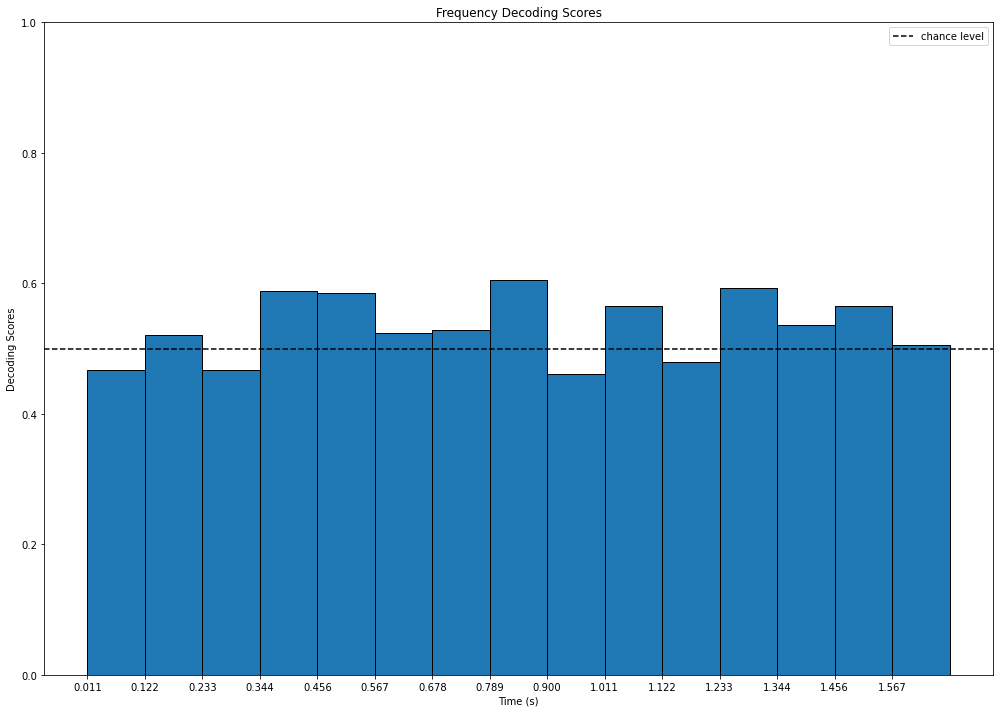

In [125]:
plt.bar(centered_w_times, tf_scores[0, :], width=np.diff(centered_w_times)[0],
        align='edge', edgecolor='black')
plt.xticks(centered_w_times)
plt.ylim([0, 1])
plt.axhline(len(epochs['hungry']) / len(epochs), color='k', linestyle='--',
            label='chance level')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Decoding Scores')
plt.title('Frequency Decoding Scores')

In [106]:
tf_scores

array([], shape=(0, 0), dtype=float64)

## Eyetrack analysis

In [2]:
gx = loadmat('rich_data/participant1_1_pilot2/eyetracking/task_2021_11_30_11_45/gx.mat')
gy = loadmat('rich_data/participant1_1_pilot2/eyetracking/task_2021_11_30_11_45/gy.mat')

In [3]:
#gx = np.mean(np.array(gx['gx']), axis=0)
#gy = np.mean(np.array(gy['gy']), axis=0)
gx = np.array(gx['gx'])[1]
gy = np.array(gy['gy'])[1]
gx[gx>2000] = 0
gy[gy>2000] = 0

In [4]:
gx_1 = gx[1:9000][::2]
gy_1 = gy[1:9000][::2]

(-1100.0, 0.0)

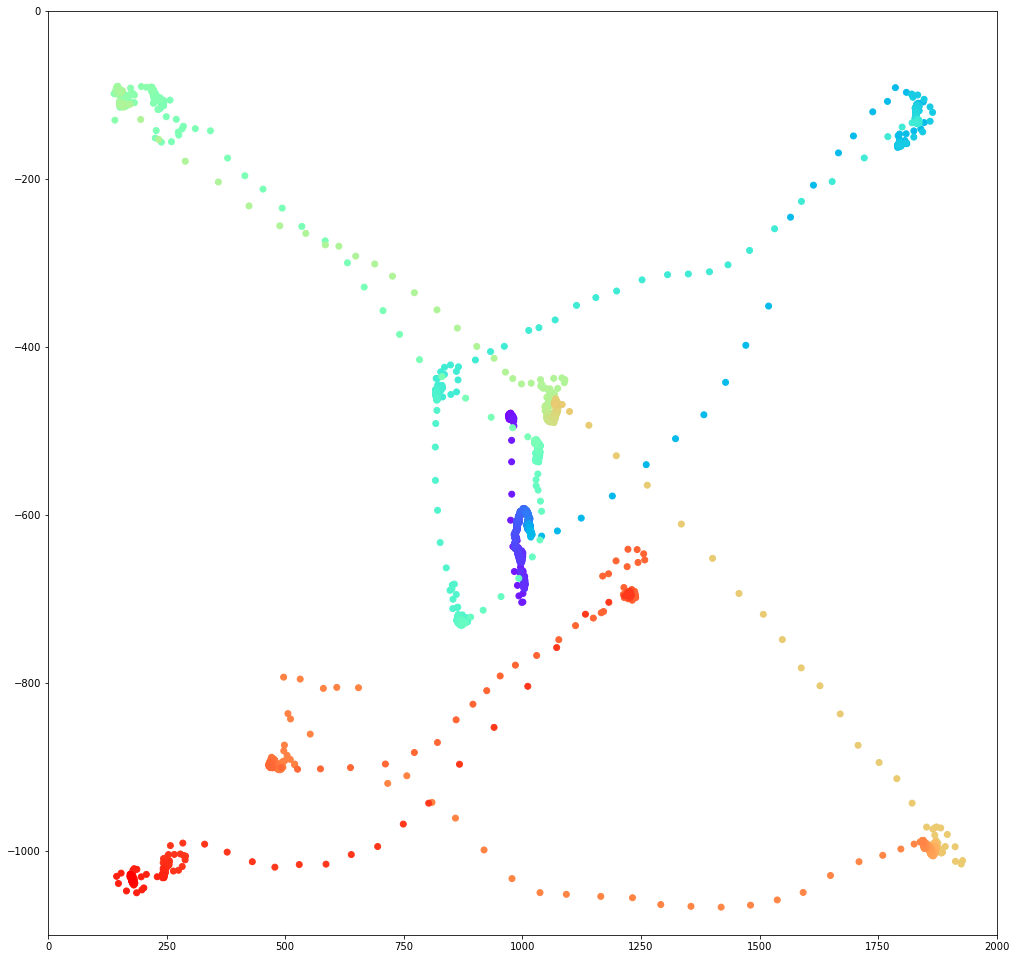

In [5]:
colors = cm.rainbow(np.linspace(0, 1, len(gx_1)))
plt.scatter(gx_1, -gy_1, color=colors)
plt.xlim([0,2000])
plt.ylim([-1100,0])

In [12]:
with open('rich_data/eyetrack_test_2/psychopy_calib') as f:
    seq = f.read()
    
seq = seq.split('[')[2:-2]
seq1 = np.array([float(s.split(',')[0]) for s in seq])
seq2 = np.array([float(s.split(' ')[1].split(']')[0]) for s in seq])

(-600.0, 0.0)

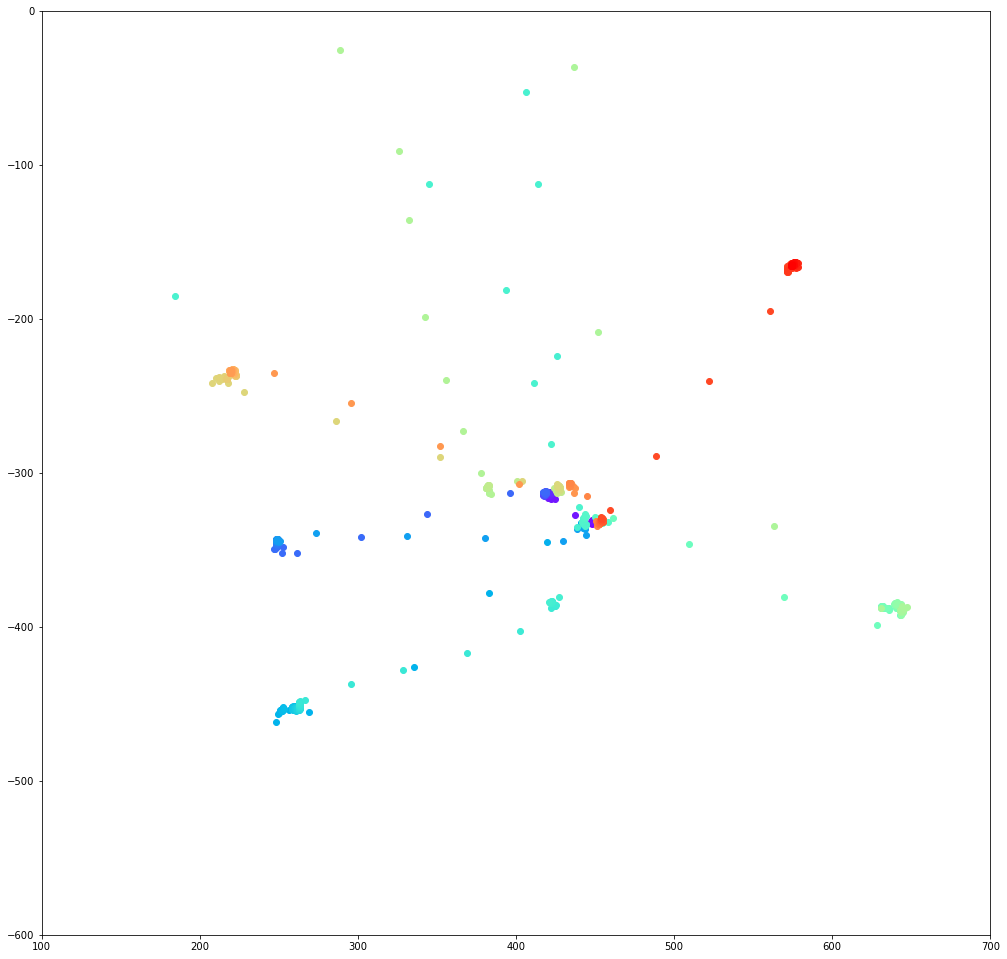

In [7]:
colors = cm.rainbow(np.linspace(0, 1, len(seq1)))
for x, y, c in zip(seq1, seq2, colors):
    plt.scatter(x, y, color=c)
plt.xlim([100,700])
plt.ylim([-600,0])

In [13]:
cx = 420
cy = -320

seq1 = cx - seq1 + cx
seq2 = cy - seq2 + cy

(-600.0, 0.0)

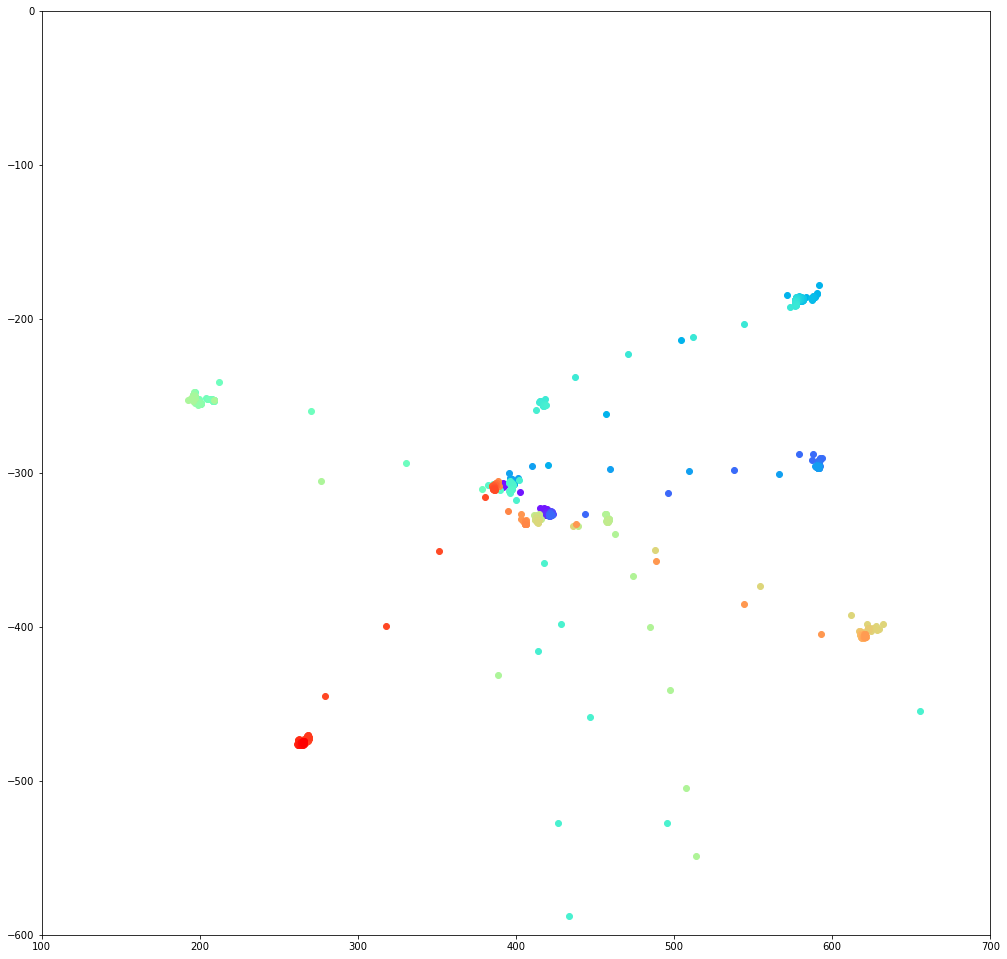

In [14]:
colors = cm.rainbow(np.linspace(0, 1, len(seq1)))
for x, y, c in zip(seq1, seq2, colors):
    plt.scatter(x, y, color=c)
plt.xlim([100,700])
plt.ylim([-600,0])

In [3]:
samples, events, messages = edf.pread('rich_data/eyetrack_test/TEST_PSY.EDF')

In [4]:
samples.keys()

Index(['time', 'px_left', 'px_right', 'py_left', 'py_right', 'hx_left',
       'hx_right', 'hy_left', 'hy_right', 'pa_left', 'pa_right', 'gx_left',
       'gx_right', 'gy_left', 'gy_right', 'rx', 'ry', 'gxvel_left',
       'gxvel_right', 'gyvel_left', 'gyvel_right', 'hxvel_left', 'hxvel_right',
       'hyvel_left', 'hyvel_right', 'rxvel_left', 'rxvel_right', 'ryvel_left',
       'ryvel_right', 'fgxvel', 'fgyvel', 'fhxyvel', 'fhyvel', 'frxyvel',
       'fryvel', 'flags', 'input', 'buttons', 'htype', 'errors'],
      dtype='object')

In [13]:
samples['gx_left']

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
86    0.0
87    0.0
88    0.0
89    0.0
90    0.0
Name: gx_left, Length: 91, dtype: float64

<IPython.core.display.Javascript object>


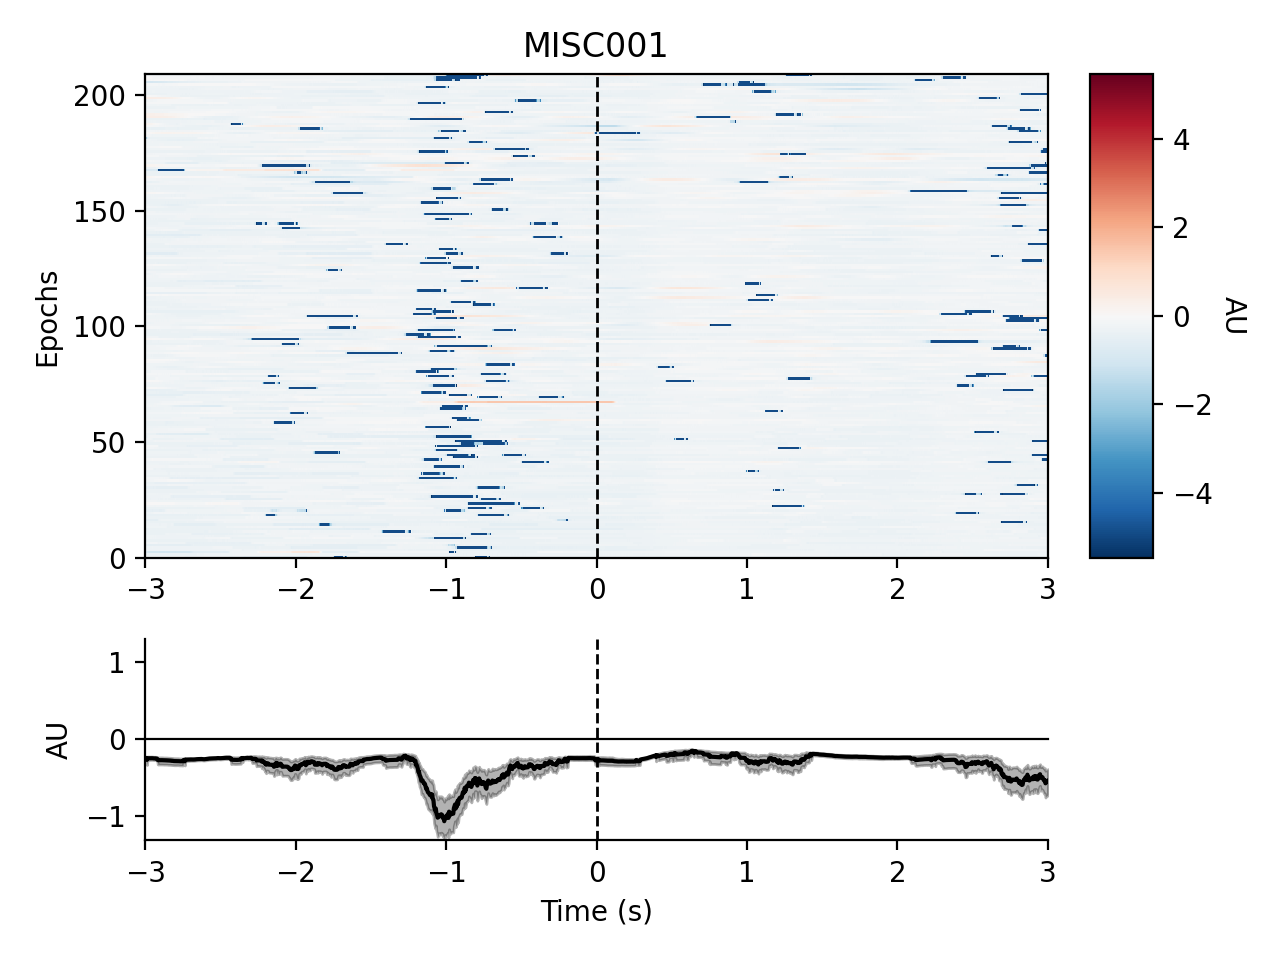

Not setting metadata
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/var/folders/nv/wjmf18wd5_j38vg9v0cthl5h0000gn/T/ipykernel_1256/719792844.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs['words'].plot_image(picks=['MISC001'])


[<Figure size 640x480 with 3 Axes>]

In [5]:
epochs['words'].plot_image(picks=['MISC001'])

<IPython.core.display.Javascript object>


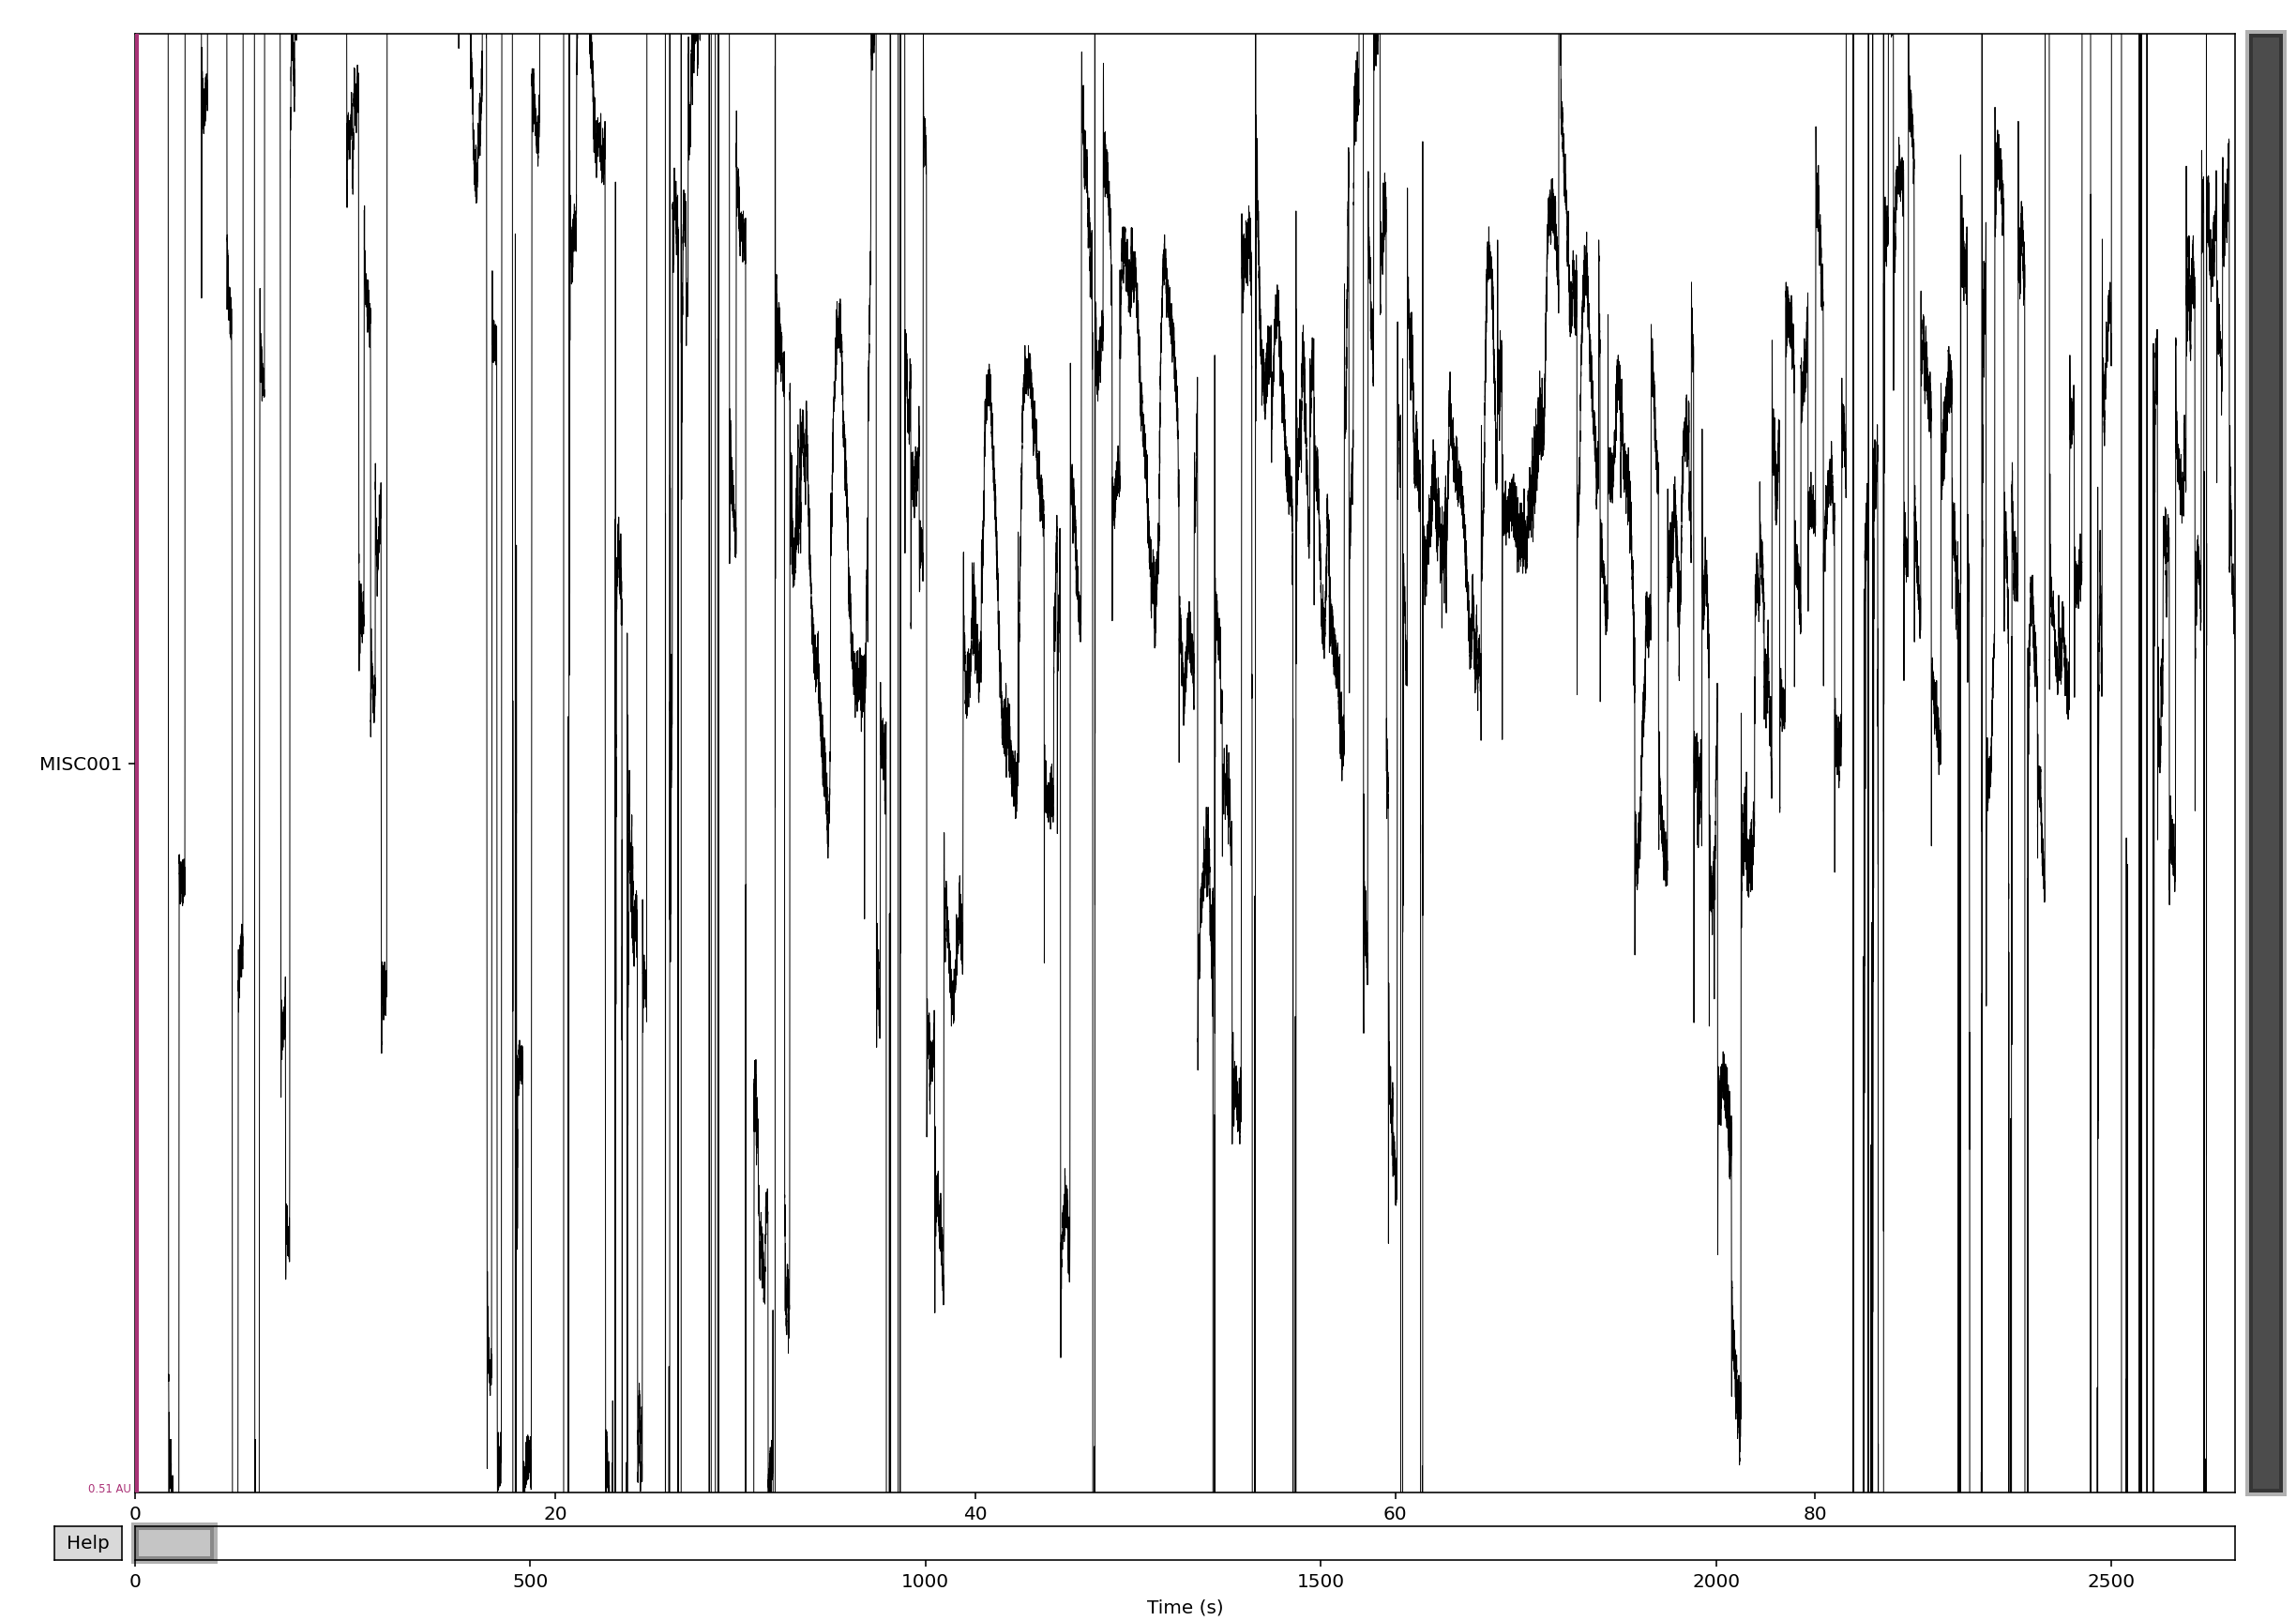

<IPython.core.display.Javascript object>


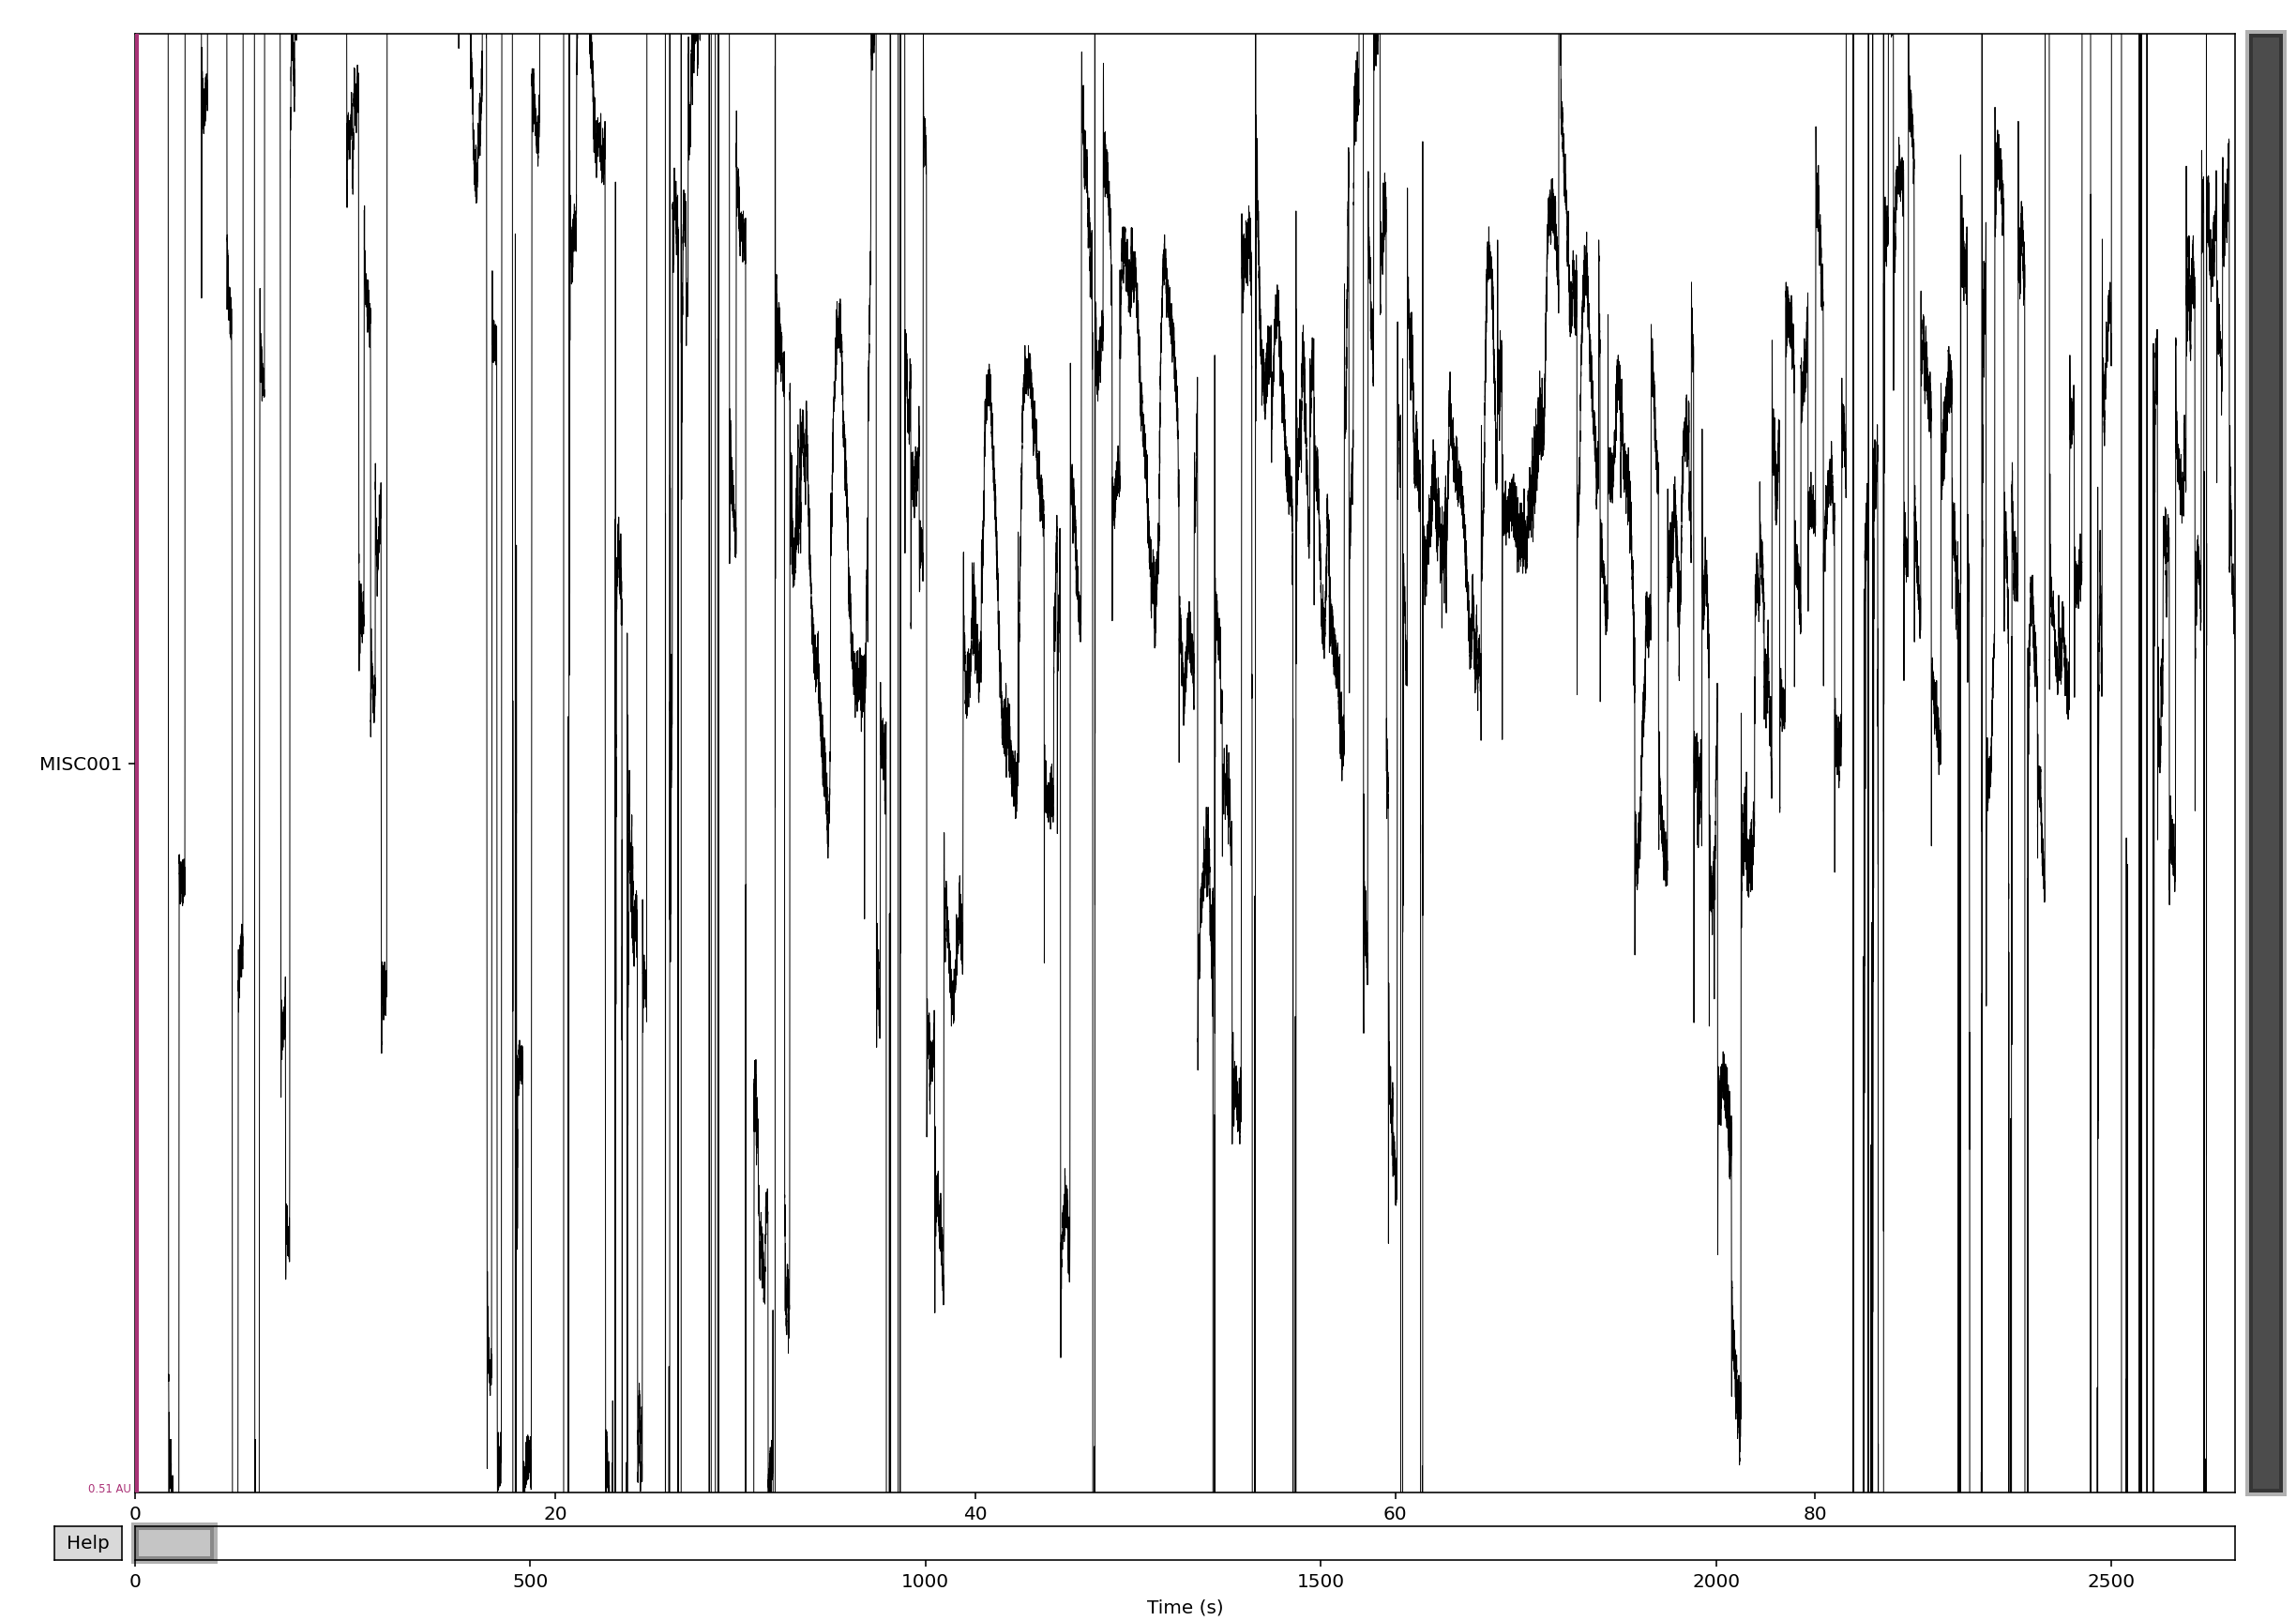

In [78]:
raw.pick(['MISC001']).plot(duration=100)

## Epoch analysis

Not setting metadata
Not setting metadata
568 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


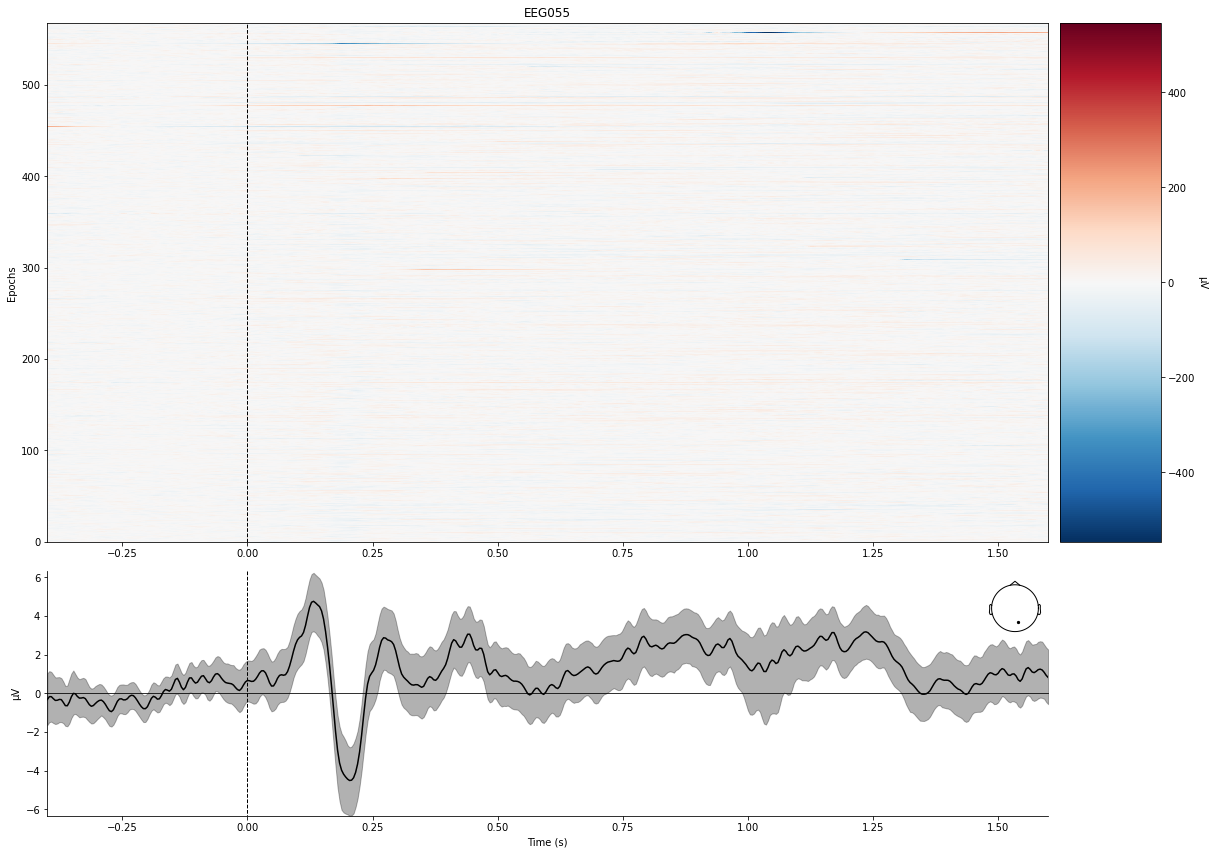

Not setting metadata
Not setting metadata
313 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


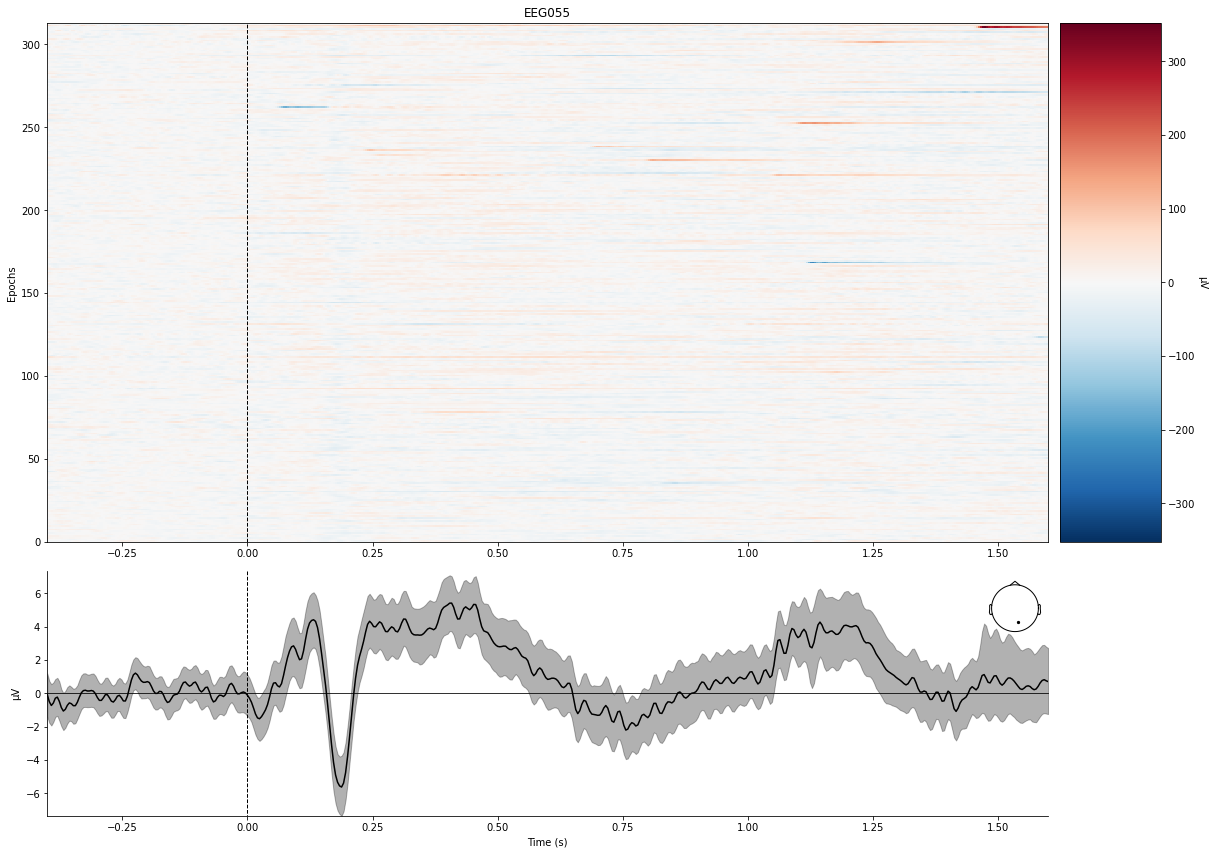

[<Figure size 1224x864 with 4 Axes>]

In [19]:
epochs['cue'].plot_image(['EEG055'])
epochs['words'].plot_image(['EEG055'])

    Using multitaper spectrum estimation with 7 DPSS windows


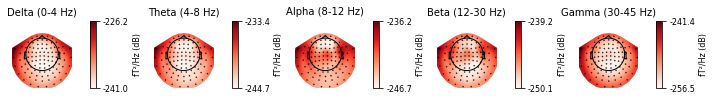

    Using multitaper spectrum estimation with 7 DPSS windows


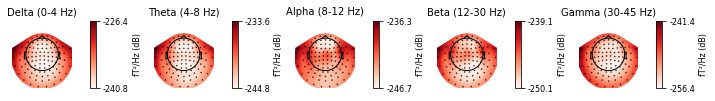

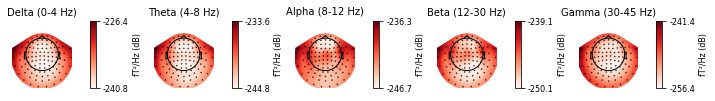

In [20]:
epochs['cue'].plot_psd_topomap()
epochs['words'].plot_psd_topomap()

## Evoked analysis

In [29]:
cue_evoked = epochs['cue'].average()
word_evoked = epochs['words'].average()

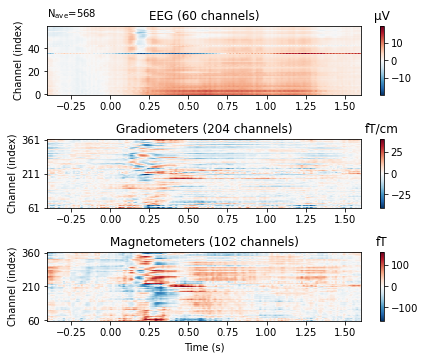

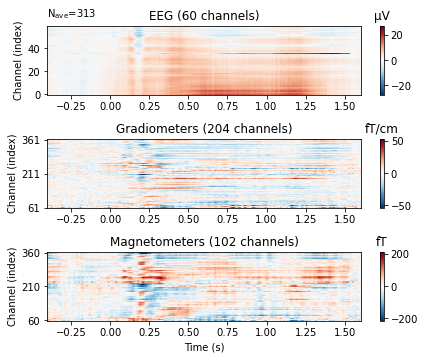

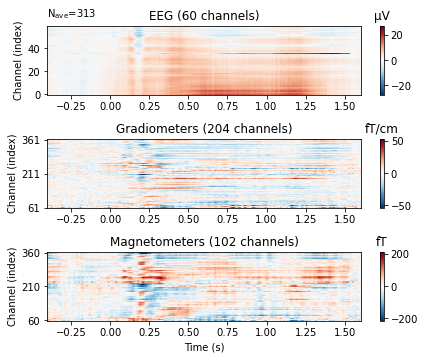

In [22]:
cue_evoked.plot_image()
word_evoked.plot_image()

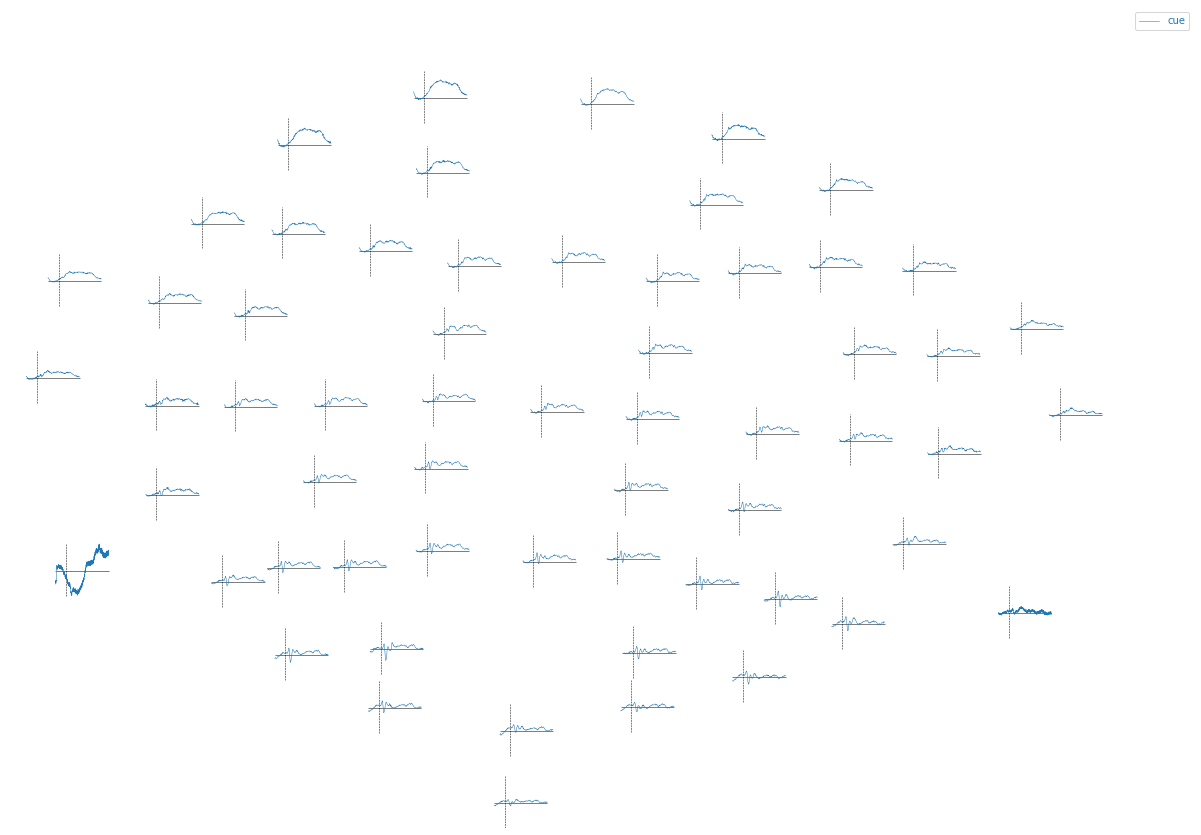

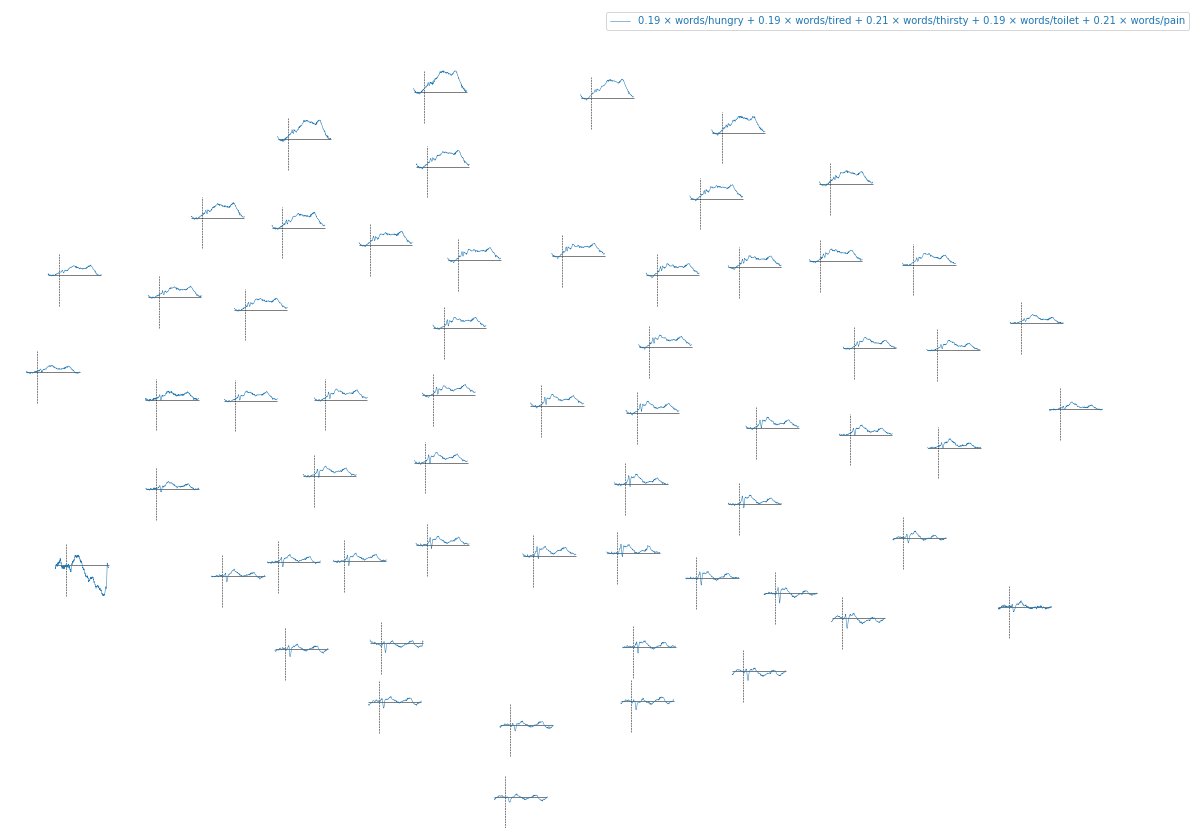

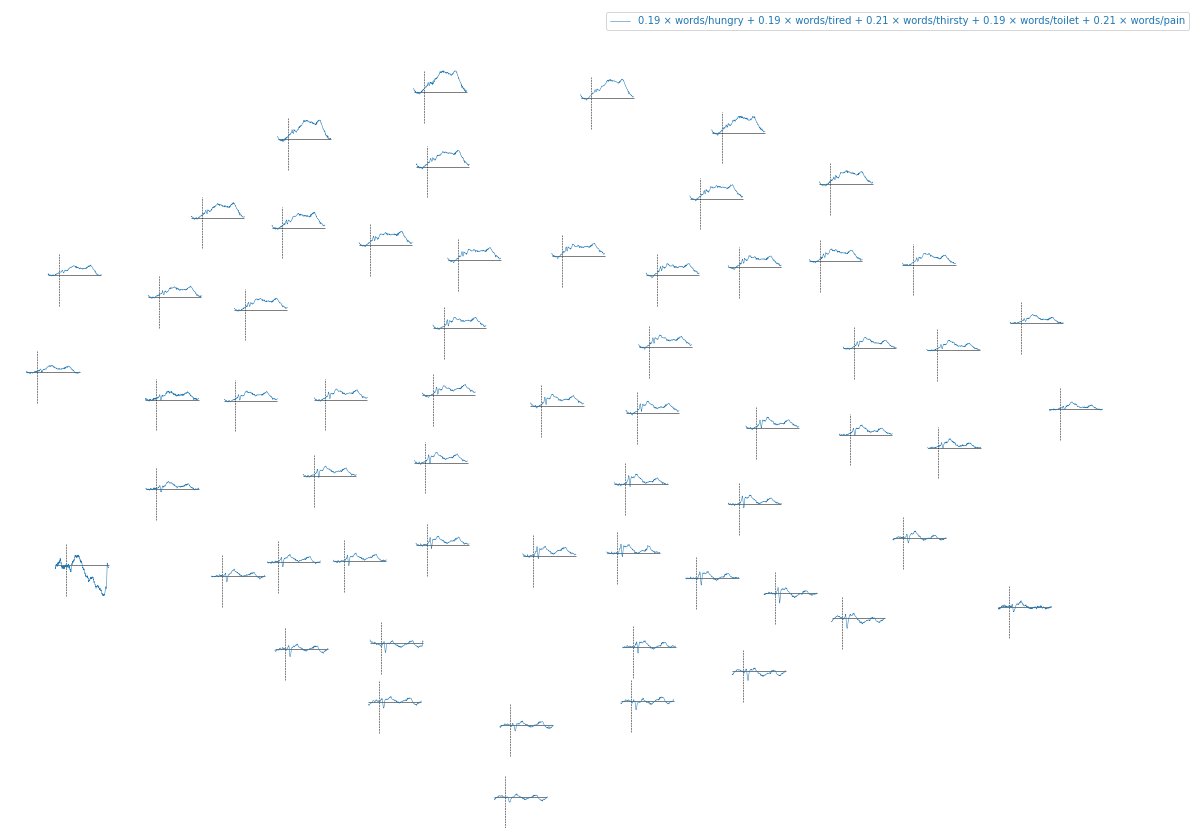

In [23]:
cue_evoked.pick('eeg').plot_topo()
word_evoked.pick('eeg').plot_topo()

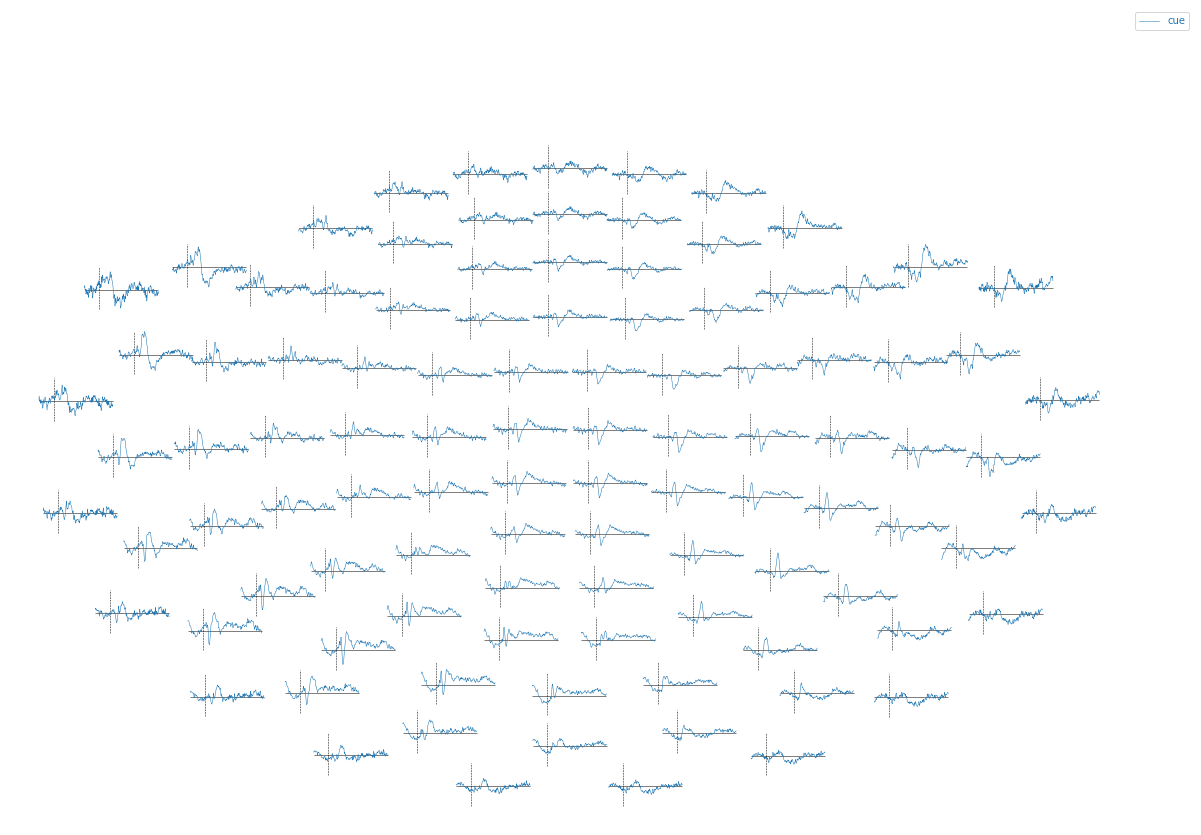

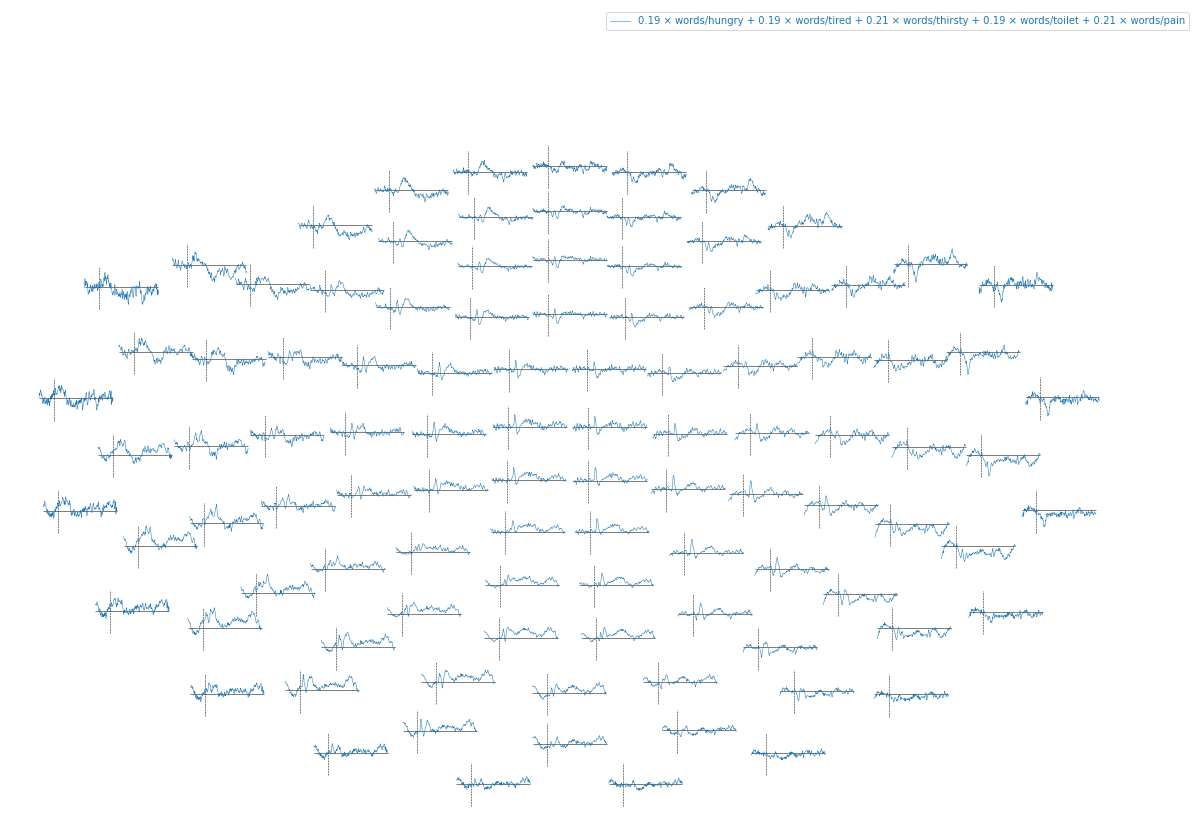

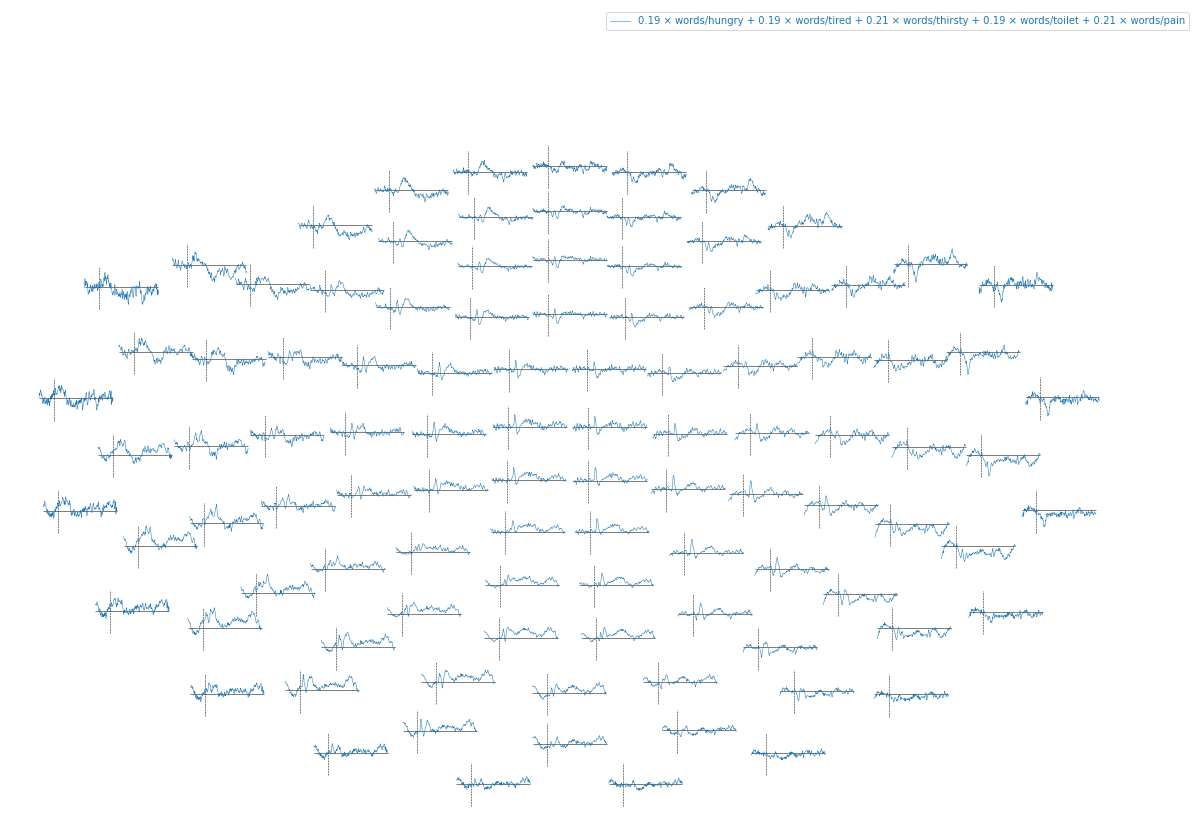

In [26]:
cue_evoked.pick('mag').plot_topo()
word_evoked.pick('mag').plot_topo()

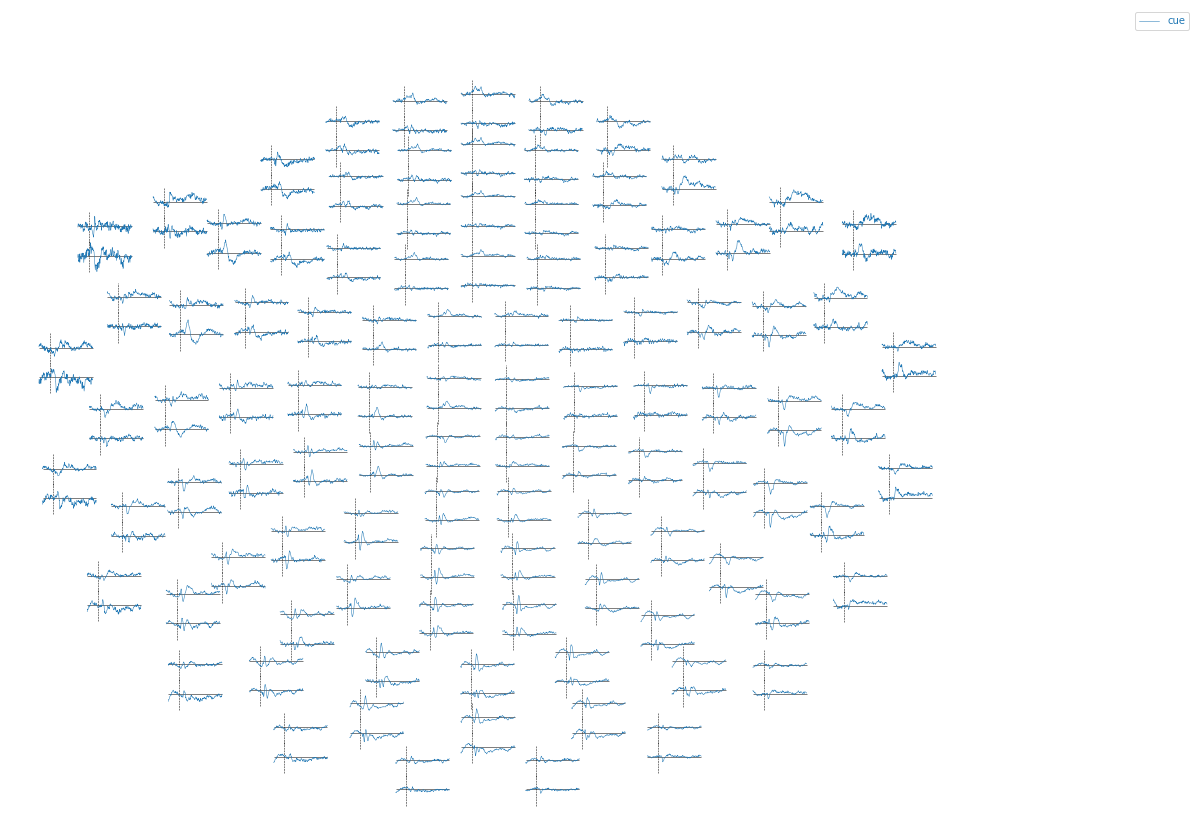

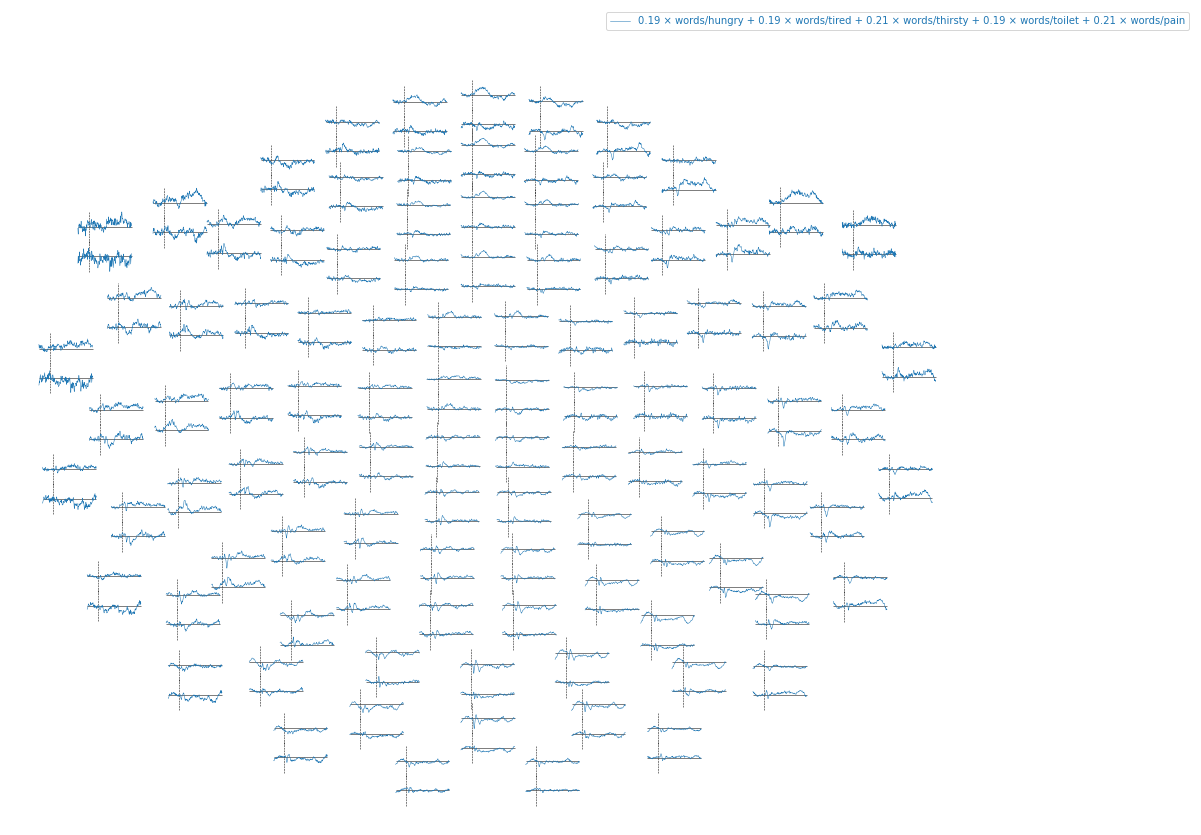

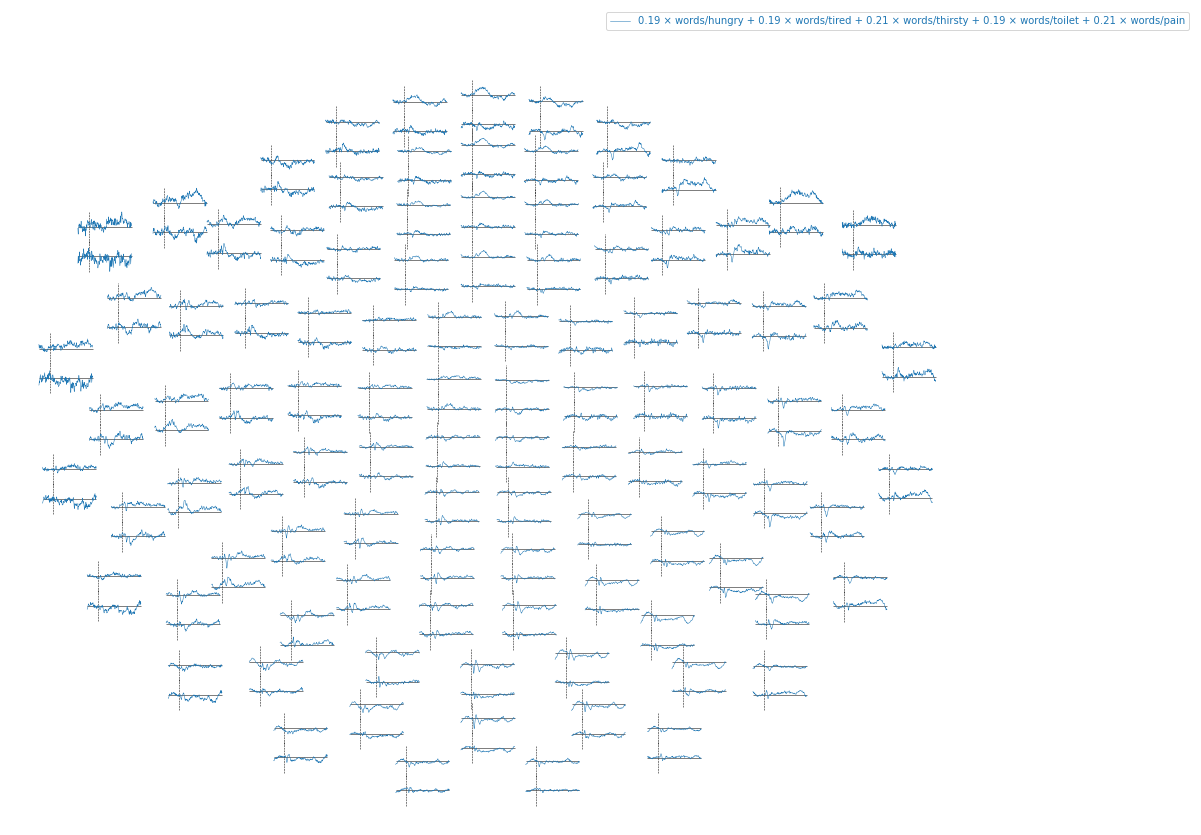

In [28]:
cue_evoked.pick('grad').plot_topo()
word_evoked.pick('grad').plot_topo()

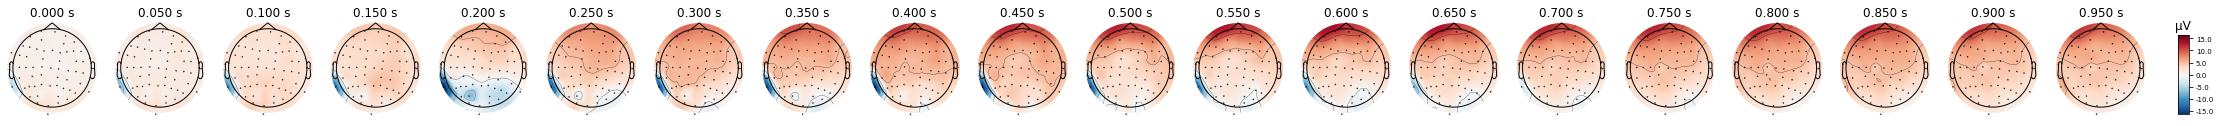

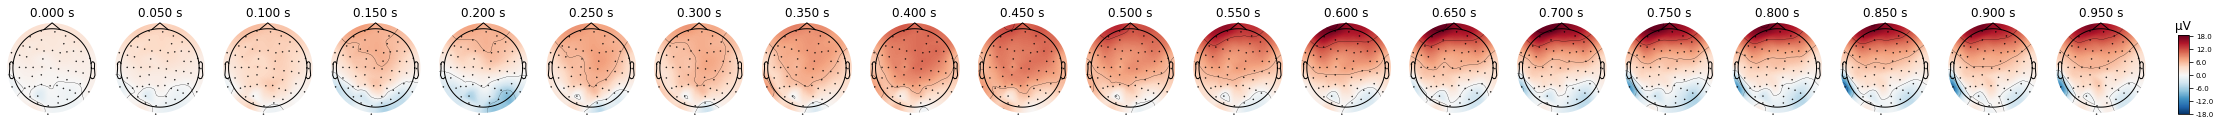

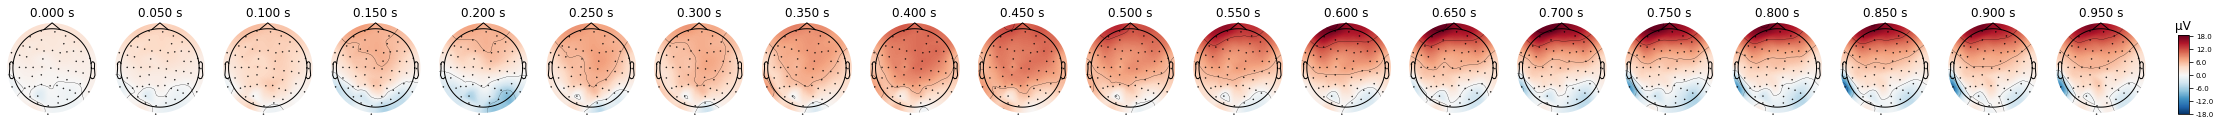

In [30]:
times = np.arange(0,1,0.05)
cue_evoked.plot_topomap(times, ch_type='eeg', average=0.05)
word_evoked.plot_topomap(times, ch_type='eeg', average=0.05)

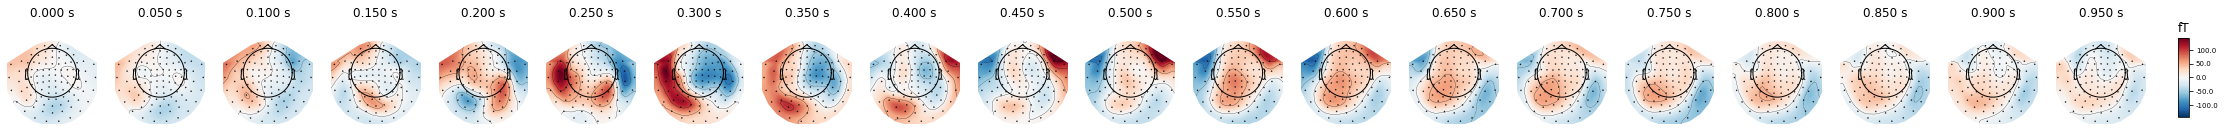

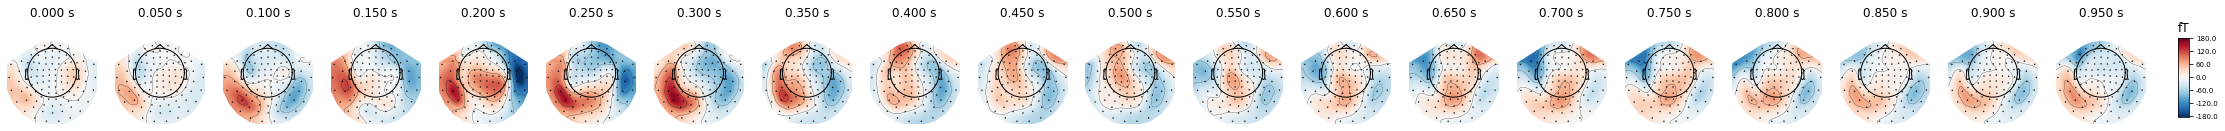

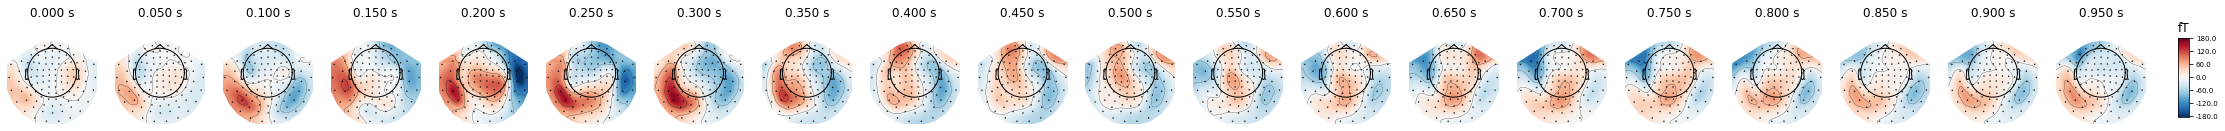

In [31]:
times = np.arange(0,1,0.05)
cue_evoked.plot_topomap(times, ch_type='mag', average=0.05)
word_evoked.plot_topomap(times, ch_type='mag', average=0.05)

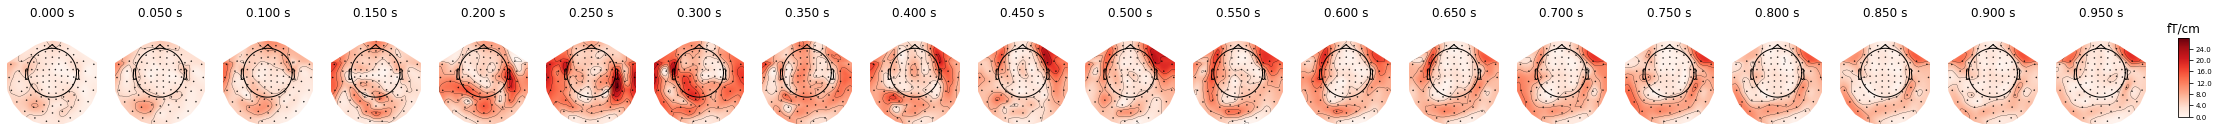

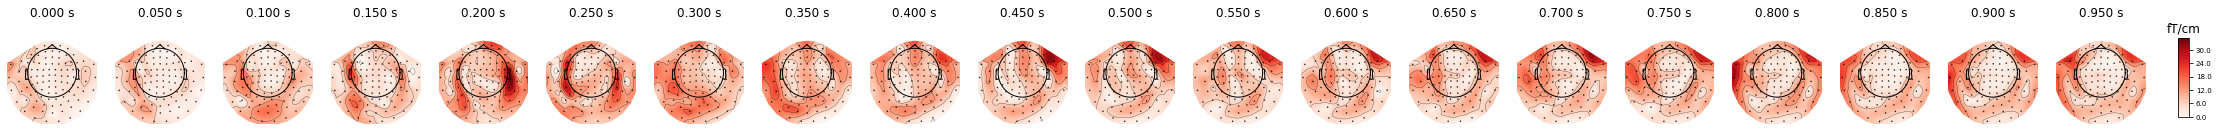

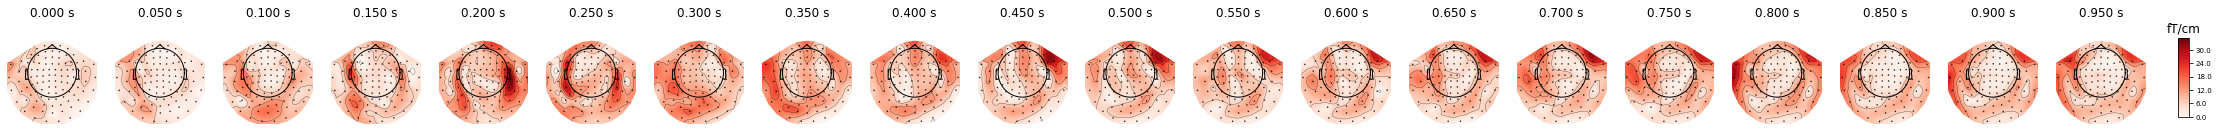

In [32]:
times = np.arange(0,1,0.05)
cue_evoked.plot_topomap(times, ch_type='grad', average=0.05)
word_evoked.plot_topomap(times, ch_type='grad', average=0.05)

<IPython.core.display.Javascript object>


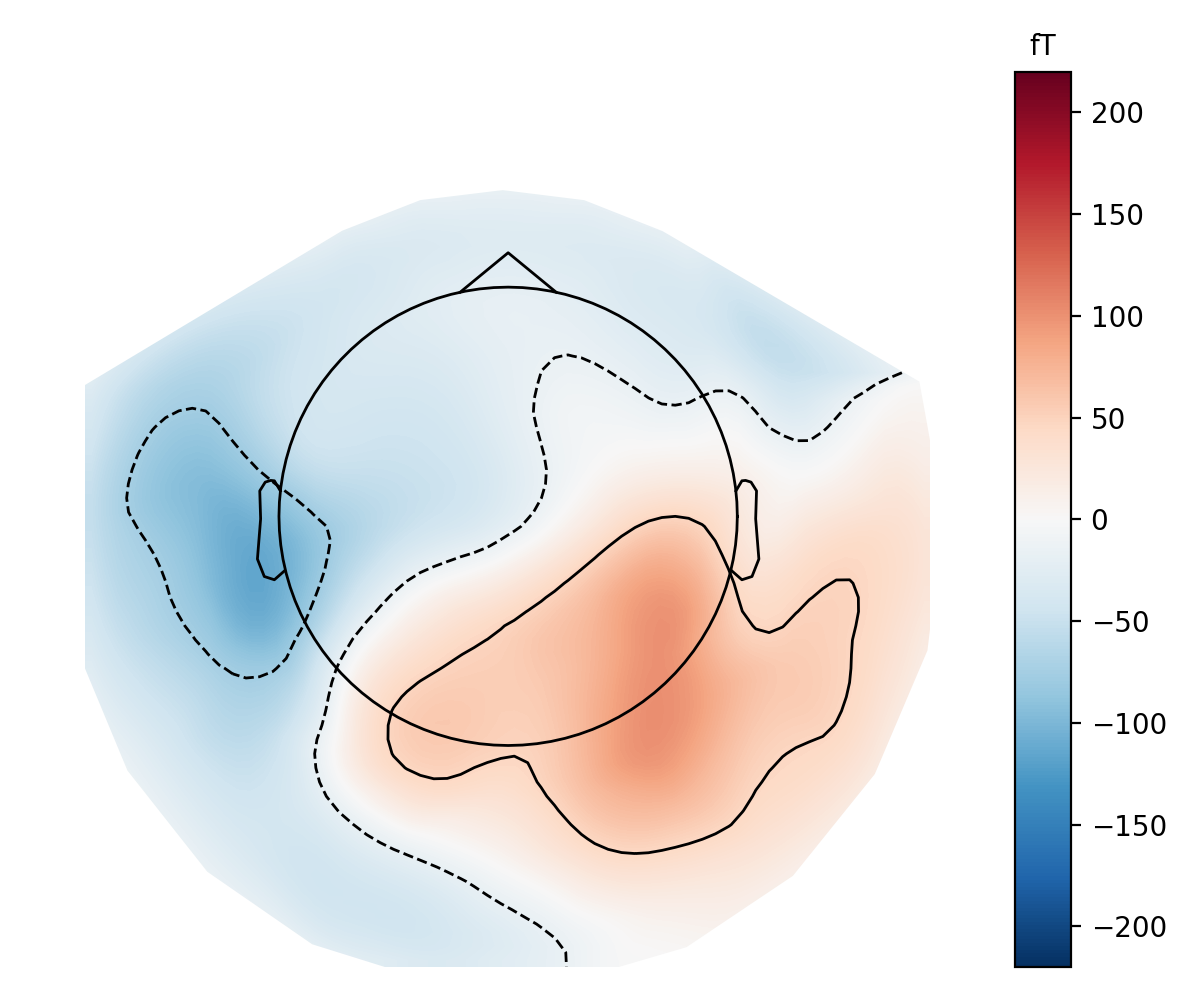

In [15]:
times = np.arange(-0.1, 0.7, 0.002)
fig, anim = cue_evoked.animate_topomap(times=times, ch_type='mag', frame_rate=10, time_unit='s', blit=False)

## ERDS analysis

In [36]:
button_epochs = epochs['button'].pick(['EEG026', 'EEG030', 'EEG032'])
freqs = np.arange(2, 36, 1)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = [-1, 0]  # baseline interval (in s)
cmap = center_cmap(plt.cm.RdBu, vmin, vmax)  # min, center, and max ERDS
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test

In [43]:
button_epochs['1']

<Epochs |  90 events (all good), -1 - 4 sec, baseline off, ~7.0 MB, data loaded,
 'button/1': 90>

Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.648811
stat_fun(H1): min=-5.912753 max=7.585894
Running initial clustering
Found 7 clusters
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 2 additional clusters to exclude from subsequent iterations
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.648811
stat_fun(H1): min=-5.912753 max=7.585894
Running initial clustering
Found 14 clusters
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.648811
stat_fun(H1): min=-5.786428 max=9.744186
Running initial clustering
Found 13 clusters
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 2 additional clusters to exclude from subsequent iterations
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.648811
stat_fun(H1): min=-5.786428 max=9.744186
Running initial clustering
Found 12 clusters
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.648811
stat_fun(H1): min=-6.478760 max=11.358831
Running initial clustering
Found 8 clusters
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.648811
stat_fun(H1): min=-6.478760 max=11.358831
Running initial clustering
Found 15 clusters
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...


  0%|          |  : 0/99 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied


/var/folders/nv/wjmf18wd5_j38vg9v0cthl5h0000gn/T/ipykernel_1116/2973247696.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


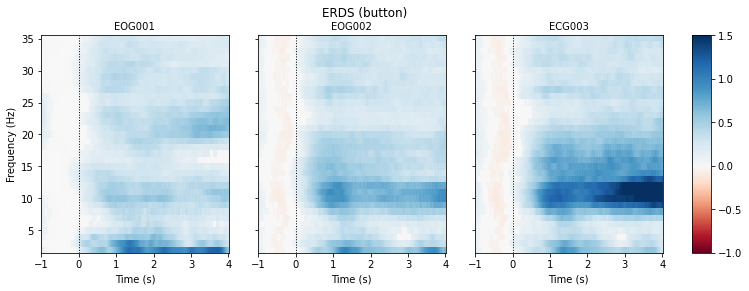

In [37]:
tfr = tfr_multitaper(button_epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(-1, 4).apply_baseline(baseline, mode="percent")


for event in ['button']:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=-1,
                                     **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
                              axes=ax, colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle("ERDS ({})".format(event))
    fig.show()

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


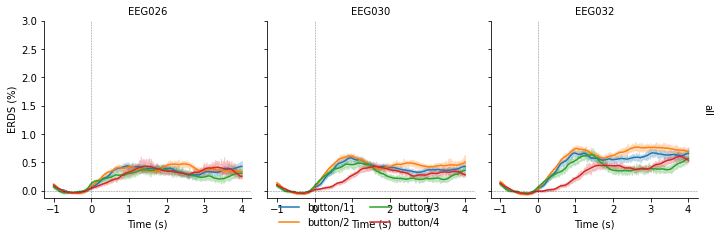

In [38]:
df = tfr.to_data_frame(time_format=None, long_format=True)
want_chs = ['EEG026', 'EEG030', 'EEG032']

# Map to frequency bands:
freq_bounds = {'_': 0,
               'all': 125}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['all']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(want_chs, ordered=True)

g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 3))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)